# Predicting United States Real Estate Prices
## By: Grace Li, Olivia Weisiger and Fionnuala Eastwood

### Link to Project on GitHub: https://github.com/0liviaWeisiger/PIC16B_FinalProject

### Outline
1. Dataset Preprocessing and Merging
2. Data Visualization
3. Classic Machine Learning Models
4. Deep Learning Models - Neural Networks
5. Analysis of Accuracy and Results

### Context
The United States housing market is...

### Our Goal

This project will explore the current United States real-estate market, investigate what factors influence the price of property, and create multiple machine learning models that predict these housing costs throughout the country. More specifically, this will be accomplished through implementation of machine learning models from logistic regression to random forest models, as well as some nerual network models. Being able to infer and understand the trends of real estate is extremely valuable economic knowledge that will provide important insights about our country. 

Furthermore, our project aims to deepen our understanding of how societal biases influence external structures such as the economy. By merging datasets, we will investigate which underlying factors such as (add briefly when choose other data) affect the prices of houses in order to draw deeper conclusions about intangible factors impacting our economic climate.

In [5]:
# pip install scikeras

### Import Packages and Data

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import plotly.express as px
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA, KernelPCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # help find hyperparameters (e.g., num of hidden layers and neurons)
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

# For NN
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Input, Activation, Dropout
from tensorflow.keras.models import Model
from keras.activations import relu, sigmoid

# For determining how many layers/neurons
# pip install scikeras # needed for below
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

2024-06-13 19:45:46.663635: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


This data is from Kaggle's "USA Real Estate Dataset" found here: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset

In [9]:
df = pd.read_csv('realtor-data.zip.csv')

### Initial Data Processing
Let's first break down what our dataset looks like...

In [11]:
df.shape

(2226382, 12)

We have a dataset with over 2 million rows and 12 columns. Since this is way too many samples to process in a reasonable computational time, we will take a random subset of 50,000 of these samples to perform analysis on. We experimented with this quantity and found that this struck an appropriate balance between computational time and accuracy.

In [13]:
random.seed(10)
df = df.sample(50000)
print(df.shape)

(50000, 12)


With our refined sample, let's get an idea of what our dataset looks like by outputting a few rows of the table.

In [15]:
df.head()

brokered_by    status     price  bed  bath  acre_lot     street  \
1729382      53196.0      sold  375000.0  3.0   2.0      0.25   339893.0   
1528605      53161.0      sold  369000.0  4.0   3.0      0.05   734531.0   
1548161     105329.0      sold  329900.0  2.0   3.0      0.05   420563.0   
339503       30300.0  for_sale  229000.0  3.0   2.0      0.50   559696.0   
755351       35506.0  for_sale  144900.0  4.0   2.0      0.12  1610178.0   

                 city           state  zip_code  house_size prev_sold_date  
1729382    Fort Myers         Florida   33919.0      1490.0     2022-01-21  
1528605       Malvern    Pennsylvania   19355.0      2088.0     2021-12-06  
1548161         Bowie        Maryland   20716.0      1120.0     2022-03-28  
339503         Sumter  South Carolina   29154.0      1706.0     2021-03-10  
755351   Battle Creek        Michigan   49015.0      1930.0     2022-02-24

Notice that each sample in the dataset is a real estate listing in the United States (the listings are all from 2022-2024), and each sample has 12 features that provide numerical or categorical information about the listing.

Here is an overview of each feature's meaning and data type:

- brokered_by: float, agency that is selling/sold property encoded numerically

- status: string, either "for_sale" or "sold" representing the status of the property on the market

- price: float, price of property listing/sale to the nearest dollar

- bed: float, number of bedrooms

- bath: float, number of bathrooms. To the nearest whole number, "half baths" are counted as full

- acre_lot: float, total lot size in acres rounded to 2 decimal places

- street: float, street of property adress encoded by integer

- city: string, name of the city the property resides in

- state: string, name of the state (or territory) the property resides in

- zip_code: float, zip code the property resides in (integer)

- house_size: float, house/living space size in square feet, rounded to nearest integer

- prev_sold_date: year-month-day, contains date it was sold if house was previously registered on market

Now that we have an understanding of our data set, we will perform some processing on the data so that it is cleaner to use. Firstly, we will drop some unnecessary columns that do not contribute to our analysis goals. The brokered_by column which encodes the real-estate company in charge of the property is not necessary because we are interested in the qualities of the house itself. Additionally, the status column is not needed because we will use the price set for the house equivalently regardless if it is sold or for sale. Lastly, the previously sold date can be dropped since we are focused on the current selling price. We will trim our dataset from 12 columns to 9 with these modifications.

In [19]:
df = df.drop(['brokered_by', 'status', 'prev_sold_date', 'street'], axis=1)

This dataset contains listings from the United States and all it's territories. For our purposes, we only want to analyze data from the 50 states (and Washington, DC) so let's trim out samples taken from Puerto Rico and the Virgin Islands.

In [21]:
df = df[(df['state'] != "Puerto Rico") & (df['state'] != "Virgin Islands")]

Our next processing step is making sure we don't have any NaN's in our dataset, as empty data values might impact our analysis models.

In [23]:
#sum up all NaN values present in dataset (in any feature column)
print (df.isnull().sum().sum())

42649


We see that we have some data entries with no value, so let's remove all rows that contain any NaN values. We will also check the shape of our data frame after this removal to make sure we still have plenty of samples to work with.

In [25]:
#remove all rows missing data
df = df.dropna()

#verify we now have no NaN values, expect a value of zero
print (f'We now have: {df.isnull().sum().sum()} NaN entires')

#print new shape
print (f'Our new dataset shape is {df.shape}')


We now have: 0 NaN entires
Our new dataset shape is (30332, 8)


We successfully dropped all empty entries and still have a substantial size data frame to analyze.

### Dataset Merging

While the relationship between features such as number of rooms or number of acres on real-estate prices is quite intuitive, this project aims to delve beyond these variables and investigate more abstract influences. This will be done by merging our current dataframe with new datasets in order to add features including minimum wage of the state, median income by zip code, and even political affiliation, as we are curious if any of these variables will display a strong correlation with housing prices. One caution to note is that our original real estate data is from the past two years, so we will need to make sure the data we are merging with is taken from the same time period in order to obtain accurate conclusions.

The first dataset we will merge with is Kaggle's "US Household Income by Zip Code 2021-2011" found here: https://www.kaggle.com/datasets/claygendron/us-household-income-by-zip-code-2021-2011

In [29]:
df_income = pd.read_csv('us_income_zipcode.csv')
df_income.head()

ZIP       Geography Geographic Area Name  Households  \
0  601  860Z200US00601          ZCTA5 00601      5397.0   
1  602  860Z200US00602          ZCTA5 00602     12858.0   
2  603  860Z200US00603          ZCTA5 00603     19295.0   
3  606  860Z200US00606          ZCTA5 00606      1968.0   
4  610  860Z200US00610          ZCTA5 00610      8934.0   

   Households Margin of Error  Households Less Than $10,000  \
0                       264.0                          33.2   
1                       448.0                          27.1   
2                       555.0                          32.1   
3                       171.0                          28.4   
4                       372.0                          20.5   

   Households Less Than $10,000 Margin of Error  \
0                                           4.4   
1                                           2.9   
2                                           2.5   
3                                           5.5   
4                                           2.5   

   Households $10,000 to $14,999  \
0                           15.7   
1                           12.7   
2                           13.4   
3                           13.3   
4                           13.2   

   Households $10,000 to $14,999 Margin of Error  \
0                                            2.9   
1                                            2.1   
2                                            1.6   
3                                            4.4   
4                                            2.5   

   Households $15,000 to $24,999  ...  \
0                           23.9  ...   
1                           20.5  ...   
2                           17.2  ...   
3                           23.3  ...   
4                           23.3  ...   

   Nonfamily Households $150,000 to $199,999  \
0                                        0.0   
1                                        0.0   
2                                        0.6   
3                                        0.0   
4                                        0.0   

   Nonfamily Households $150,000 to $199,999 Margin of Error  \
0                                                2.8           
1                                                1.3           
2                                                0.6           
3                                                7.5           
4                                                1.8           

   Nonfamily Households $200,000 or More  \
0                                    0.0   
1                                    0.0   
2                                    0.2   
3                                    0.0   
4                                    0.0   

   Nonfamily Households $200,000 or More Margin of Error  \
0                                                2.8       
1                                                1.3       
2                                                0.4       
3                                                7.5       
4                                                1.8       

   Nonfamily Households Median Income (Dollars)  \
0                                        9386.0   
1                                       11242.0   
2                                       10639.0   
3                                       15849.0   
4                                       12832.0   

   Nonfamily Households Median Income (Dollars) Margin of Error  \
0                                             1472.0              
1                                             1993.0              
2                                              844.0              
3                                             3067.0              
4                                             2405.0              

   Nonfamily Households Mean Income (Dollars)  \
0                                     13044.0   
1                                     16419.0   
2                           

This dataset contains the results of the 2011 and 2021 national census, and we have chosen it in order to add a median income feature to our real estate pricing dataset. As explained above, we are only interested in the 2021 data since our pricing data comes from recent years, so we will trim down our dataset accordingly. Additionally, the dataset comes with dozens of feature columns, but for our purposes we only need to keep the zip code column (which we will use to merge our original dataset), and the median household income column. So let's process our dataset and display the cleaner result.

In [31]:
#select only samples from most recent census
df_income = df_income[df_income["Year"] == 2021.0]

#select only features we want
df_income = df_income[["ZIP", "Nonfamily Households Median Income (Dollars)"]]

df_income.head()

ZIP  Nonfamily Households Median Income (Dollars)
0  601                                        9386.0
1  602                                       11242.0
2  603                                       10639.0
3  606                                       15849.0
4  610                                       12832.0

Now we are ready to merge with our original dataset. Currently our zip code columns have different names so we will rename them identically, and they also have different types (integer vs float) so we will convert to a float variable to avoid type error interference.

In [33]:
#convert to float
df_income["ZIP"] = df_income["ZIP"].astype(float)

#rename columns
df_income = df_income.rename(columns={'ZIP': 'zip_code', "Nonfamily Households Median Income (Dollars)": 'income'})

We will use an inner merge (explain why...)
The census data was very thorough (we have very few NaN values), so we can just remove any empty data rows and our dataset remains practically the same. We verify this assumption by outputting our dataset shape after the merge.

In [35]:
#perform merge
df = pd.merge(df, df_income, on = ["zip_code"])

#remove all rows missing data
df = df.dropna()

print (df.shape)
df.head()

(30003, 9)


price  bed  bath  acre_lot          city           state  zip_code  \
0  375000.0  3.0   2.0      0.25    Fort Myers         Florida   33919.0   
1  369000.0  4.0   3.0      0.05       Malvern    Pennsylvania   19355.0   
2  329900.0  2.0   3.0      0.05         Bowie        Maryland   20716.0   
3  229000.0  3.0   2.0      0.50        Sumter  South Carolina   29154.0   
4  144900.0  4.0   2.0      0.12  Battle Creek        Michigan   49015.0   

   house_size   income  
0      1490.0  40117.0  
1      2088.0  83676.0  
2      1120.0  84412.0  
3      1706.0  38044.0  
4      1930.0  34820.0

This feature looks good, let's move on to some more merges.

Next, we want to add to our dataset statistics on political affiliation by state and minimum wage by state, which should be slightly simpler than merging by zipcode. 

First we will use is Kaggle's "2020 US Presidential Election Results by State" linked here: https://www.kaggle.com/datasets/callummacpherson14/2020-us-presidential-election-results-by-state. This data was taken appropriately recently to match our real-estate data, and it contains voting percentage and win vs loss data on Biden and Trump from the 2020 election.


In [37]:
df_election = pd.read_csv('voting.csv.xls')
df_election.head()

state state_abr  trump_pct  biden_pct  trump_vote  biden_vote  \
0      Alaska        AK       53.1       43.0      189543      153502   
1      Hawaii        HI       34.3       63.7      196864      366130   
2  Washington        WA       39.0       58.4     1584651     2369612   
3      Oregon        OR       40.7       56.9      958448     1340383   
4  California        CA       34.3       63.5     5982194    11082293   

   trump_win  biden_win  
0          1          0  
1          0          1  
2          0          1  
3          0          1  
4          0          1

Notice this is quite a clean dataset already, all we need to do is select the columns we are interested in and perform another inner merge along the column column of state. Here, we will choose to keep the state column which is needed for the merge, as well as the Trump pct, Biden pct columns since these provide more detailed information then the binary win vs loss columns. Let's do so and check our new dataset.

In [39]:
#select only features we want
df_election = df_election[["state", "biden_pct", "trump_pct"]]

#merge dataframe along the column of state
df = pd.merge(df, df_election, on = ["state"])

#verify there were no null data values added
print (f'We still have: {df.isnull().sum().sum()} NaN entires')

#output model summary
print (df.shape)
df.head()

We still have: 0 NaN entires
(30003, 11)


price  bed  bath  acre_lot          city           state  zip_code  \
0  375000.0  3.0   2.0      0.25    Fort Myers         Florida   33919.0   
1  369000.0  4.0   3.0      0.05       Malvern    Pennsylvania   19355.0   
2  329900.0  2.0   3.0      0.05         Bowie        Maryland   20716.0   
3  229000.0  3.0   2.0      0.50        Sumter  South Carolina   29154.0   
4  144900.0  4.0   2.0      0.12  Battle Creek        Michigan   49015.0   

   house_size   income  biden_pct  trump_pct  
0      1490.0  40117.0       47.9       51.2  
1      2088.0  83676.0       50.0       48.8  
2      1120.0  84412.0       65.8       32.4  
3      1706.0  38044.0       43.4       55.1  
4      1930.0  34820.0       50.6       47.8

Notice we still have no NaN entries, so our merging didn't add any problematic data and appears to be successfully added. 

Finally, we will perform this process one more time in order to add data on what each state's minimum wage is. This time we will use Kaggle's "Living Wage - State Capitals" found at https://www.kaggle.com/datasets/brandonconrady/living-wage-state-capitals. We again verified this was taken from the past two years for consistency.

In [41]:
df_minwage = pd.read_csv('LivingWageStateCapitals.csv.xls')
df_minwage.head()

state_territory         city  minimum_wage  \
0  District of Columbia   Washington         13.25   
1               Alabama   Montgomery          7.25   
2                Alaska       Juneau         10.19   
3               Arizona      Phoenix         12.00   
4              Arkansas  Little Rock         10.00   

   one_adult_no_kids_living_wage  one_adult_one_kid_living_wage  \
0                          19.97                          38.95   
1                          13.56                          27.35   
2                          15.48                          29.99   
3                          15.41                          29.44   
4                          13.97                          28.81   

   one_adult_two_kids_living_wage  one_adult_three_kids_living_wage  \
0                           48.99                             63.96   
1                           33.42                             42.17   
2                           36.00                             47.42   
3                           35.40                             46.01   
4                           35.49                             45.33   

   two_adults_one_working_no_kids_living_wage  \
0                                       29.61   
1                                       22.59   
2                                       24.48   
3                                       24.85   
4                                       23.21   

   two_adults_one_working_one_kid_living_wage  \
0                                       34.55   
1                                       26.66   
2                                       29.46   
3                                       29.25   
4                                       27.66   

   two_adults_one_working_two_kids_living_wage  ...  \
0                                        38.32  ...   
1                                        30.27  ...   
2                                        33.01  ...   
3                                        32.98  ...   
4                                        31.36  ...   

   one_adult_two_kids_poverty_wage  one_adult_three_kids_poverty_wage  \
0                            10.44                              12.60   
1                            10.44                              12.60   
2                            13.05                              15.75   
3                            10.44                              12.60   
4                            10.44                              12.60   

   two_adults_one_working_no_kids_poverty_wage  \
0                                         8.29   
1                                         8.29   
2                                        10.36   
3                                         8.29   
4                                         8.29   

   two_adults_one_working_one_kid_poverty_wage  \
0                                        10.44   
1                                        10.44   
2                                        13.05   
3                                        10.44   
4                                        10.44   

   two_adults_one_working_two_kids_poverty_wage  \
0                                         12.60   
1                                         12.60   
2                                         15.75   
3                                         12.60   
4                                         12.60   

   two_adults_one_working_three_kids_poverty_wage  \
0                                           14.75   
1                                           14.75   
2                                           18.44   
3                                           14.75   
4                                           14.75   

   two_adults_both_working_no_kids_poverty_wage  \
0                                          4.14   
1                                          4.14   
2                                          5.18   
3                                          4.14   
4         

Again, we want to select the columns we need which in this case is the state column to merge along and the minimum_wage column which has the minimum wage data we desire (in dollars). Here, we will also rename the "state_territory" column to have the same title "state" as our original dataframe to streamline the merging process. Then after we complete the inner merge we will verify our final dataset.

In [43]:
#select only features we want
df_minwage = df_minwage[["state_territory", "minimum_wage"]]

#rename state_territory column
df_minwage = df_minwage.rename(columns={'state_territory': 'state'})

#merge dataframe along the column of state
df = pd.merge(df, df_minwage, on = ["state"])

#verify there were no null data values added
print (f'We still have: {df.isnull().sum().sum()} NaN entires')

#output model summary
print (df.shape)
df.head()

We still have: 0 NaN entires
(30003, 12)


price  bed  bath  acre_lot          city           state  zip_code  \
0  375000.0  3.0   2.0      0.25    Fort Myers         Florida   33919.0   
1  369000.0  4.0   3.0      0.05       Malvern    Pennsylvania   19355.0   
2  329900.0  2.0   3.0      0.05         Bowie        Maryland   20716.0   
3  229000.0  3.0   2.0      0.50        Sumter  South Carolina   29154.0   
4  144900.0  4.0   2.0      0.12  Battle Creek        Michigan   49015.0   

   house_size   income  biden_pct  trump_pct  minimum_wage  
0      1490.0  40117.0       47.9       51.2          8.56  
1      2088.0  83676.0       50.0       48.8          7.25  
2      1120.0  84412.0       65.8       32.4         11.00  
3      1706.0  38044.0       43.4       55.1          7.25  
4      1930.0  34820.0       50.6       47.8          9.65

### Data Visualization

Our data visualization is necessary to serve two main purposes: the first being to come to conclusions about what factors (especially non-obvious ones like political affiliation for example) have a significant effect on housing prices. Recall that one of our main goals of this project was to investigate the role of these subtle biases on the housing market, and our visualization should allow us to conclude whether or not these patterns exist. The second purpose of visualization is to observe the impacts of individual features on our target column in order to inform our future models on how to prepare the dataset for machine learning algorithms.

First, let's get a general idea of what our dataset contains starting with our most important variable: price. I will display distribution plots of where our prices fall using a histogram, boxplot and violinplot. Notice that to aid the aesthetic of the visual (to prevent the x axis being too stretched out by outliers making the main shape more compressed) I eliminated the top and bottom 3% of prices.

/Users/fionnualaeastwood/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


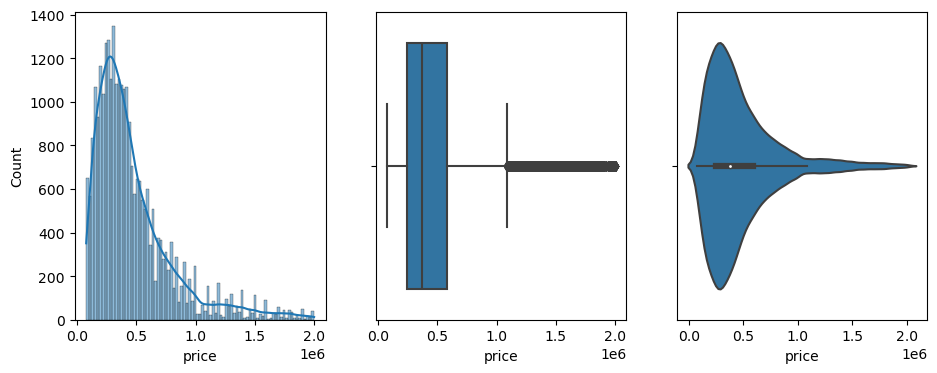

In [45]:
fig, axes = plt.subplots(1,3, figsize=(11, 4))

# Calculate the 3rd and 97th percentiles
lower_bound = df['price'].quantile(0.03)
upper_bound = df['price'].quantile(0.97)

# Filter the DataFrame to exclude the top and bottom 3% of prices
df_outliers = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Create a boxplot using Seaborn
sns.histplot(x='price', data=df_outliers, ax=axes[0], kde = True)

# Create a barplot using Seaborn
sns.boxplot(x='price', data=df_outliers, ax=axes[1])

# Create a violin plot using Seaborn
sns.violinplot(x='price', data=df_outliers, ax=axes[2])

plt.show()

We observe that our price data has a large clustering around median of aproximately 0.4 million, along with a skew right. Most of our data is clustered around the quarter million to half million range, but there are some very expensive samples that create the tail dragging in the high-priced direction. This makes logical sense given what we know about the housing market, as most homes are moderate sized and extremely expensive properties become more and more rare. We will be interested in exploring what features are present in these high-priced data points, as these will likely be our indicators of what determines an expensive property.

Now let's take a look at the distribution of our variables of house size, bed, and bath. Again we will ignore some outliers in order to highlight the shape of our distribution (if we extended the x axis farther to the right we would continue to see a practically flat zeroed out line)

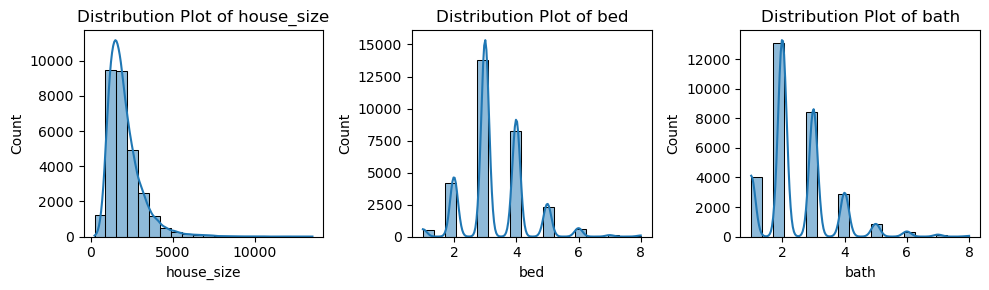

In [47]:
# prevent warnings from appearing
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

num_cols = ['house_size','bed', 'bath']

df_outliers = df.query('bed<=8 and bath <= 8 and house_size<= 15000')

# set up the plot
fig, axes = plt.subplots(1,3, figsize=(10, 3))

# loop through the numeric columns and plot the distributions
for i, col in enumerate(num_cols):
    
    sns.histplot(df_outliers[col], ax=axes[i], kde=True, bins = 20)

    axes[i].set_title(f"Distribution Plot of {col}", wrap=True)
    axes[i].set_xlabel(col)
    
fig.tight_layout()

plt.show()

Similarly to price, these variables appear about as we would logically expect which indicates that our dataset did a good job sampling the real-world housing market. They each are unimodal with a slight skew to the right, which seems to mimick the price graph. Since the distributions appear similar, this may be a hint that these three variables have a strong correlation with price (or there is some underlying variable associated with both of them), which we will investigate farther later.

Next, let's look at the categorical variable of state, and verify how many data points of property we have per state. This time I perferred the formating of plotly to create a readable barplot.

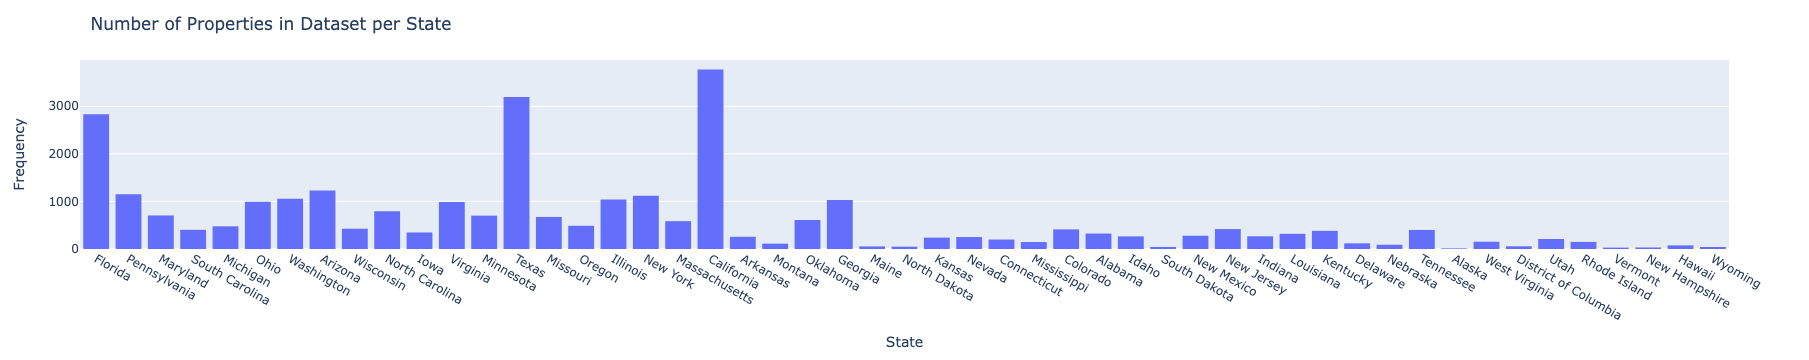

In [49]:
# Create a histogram using Plotly
fig = px.histogram(x=df["state"])

# Update layout
fig.update_layout(
    title="Number of Properties in Dataset per State",
    xaxis_title="State",
    yaxis_title="Frequency",
    showlegend=False
)

# Show the plot
fig.show()

We see that we have the most data samples coming from our large and populous states such as Florida, California, and Texas, while fewer samplings coming from smaller or more rural states. This also verifies that there are some samplings present from all 50 states. Based on this, our dataset seems to provide a pretty nice picture of the US housing market as a whole.

Now let's begin to investigate the impact of certain features on price, starting with a correlation map. This will use numerical data, so let's manually include some numerical features we are interested in, along with the price and above average price target columns.

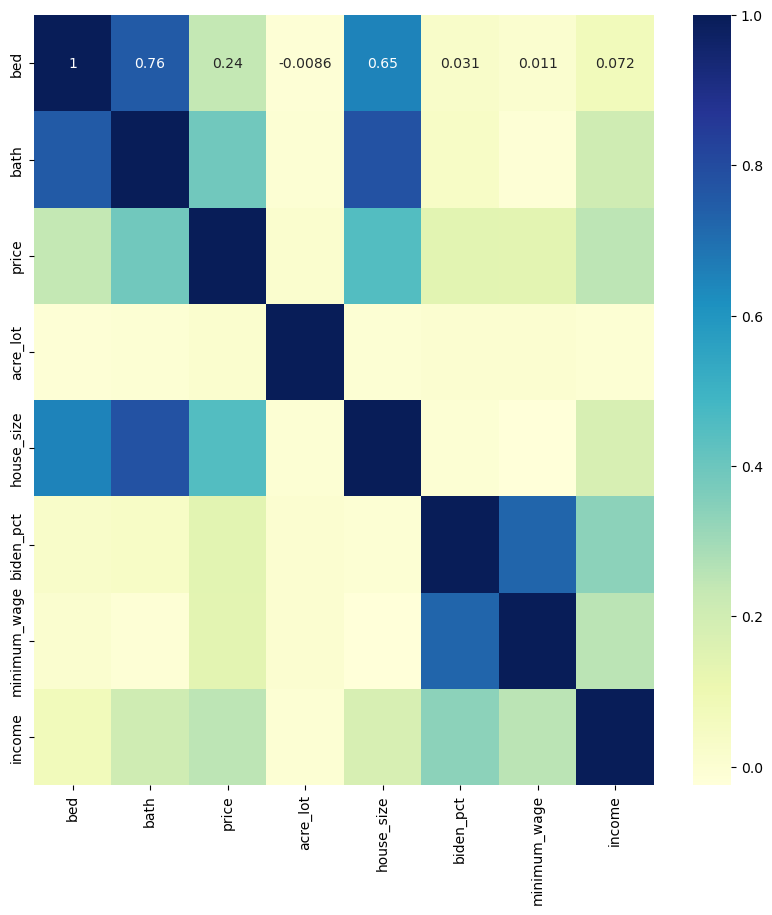

In [51]:
#take columns of numerical data we are interested in
df_corr = df[['bed', 'bath', 'price','acre_lot', 'house_size', 'biden_pct', 'minimum_wage', 'income']]

#correlation map
corr_data = df_corr.corr()

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_data, cmap="YlGnBu", annot = True)

plt.show()

A couple important conclusions come out of this heatmap:
1) This points out the need for standardization. Notice that acre_lot is extremely uncorrelated to every variable, despite house_size which is a pretty similar variable having some noticeable correlations. This is likely because the acre quantity is so small that most of its values are small fractions which our machine is reading as insignificant in comparison to the larger numbers in other columns. So this reminds us to standardize our data before we use it for machine learning models
2) Bed, bath, and income appear to be our most strongly correlated variables with price. We will keep an eye out for these later as they are likely going to be more impactful to our models

Now let's analyze one of our major categorical features: state. The natural way to create a state vs price visual is to display on a map! We will create a choropleth map of the united states, where each state contains its mean housing price. This is done by using the groupby function as well as the plotly packages to visualize.

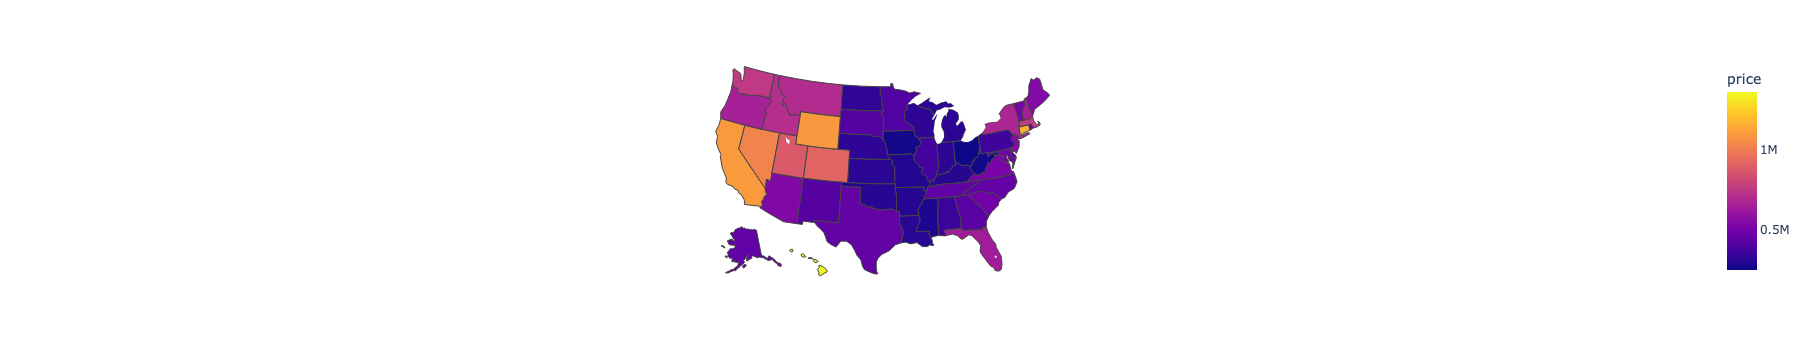

In [53]:
#create a subset of our dataframe to use for this plot
uniquestate_df = df[['state', 'price']]

#group by state to obtain the average price of all samples in each state
uniquestate_df = uniquestate_df.groupby('state', as_index=False).mean()

state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Map the state names to abbreviations
uniquestate_df['state_abbrev'] = uniquestate_df['state'].map(state_abbrev)

fig = px.choropleth(uniquestate_df, locations="state_abbrev",
                    locationmode="USA-states",
                    color="price",
                    scope = "usa",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

Our state map leads to some very interesting conclusions. Somewhat expectedly, California appears to be one of the most expensive states along with Hawaii, and the midwestern region states appear to be the chepest. We were  surprised that New York was not more expensive, but given that our data focuses on housing listings not apartments, and uses price as a whole not price per square foot it makes sense that urban areas like New York City hold less gravity than one would think. These intricacies to our dataset are important to note to fully understand our setup. 

Additionally, noticing how much our prices fluctuate per state leads to an interesting point that what is considered "expensive" in one state is not necessarily considered expensive in another. So when we look forward into creating models, it appears we may want to have some kind of normalization or comparison to one's state, when classifying a property as expensive or not.

Now along the same lines of state, let's move on to some of our more "fun" analysis. We want to conclude whether political affiliation and state minimum wage (2 of our merged datasets) appear to have any correlation with housing price. To do this let's again group by state to find the mean price for each state, and create plots that display a regression line and confidence interval for the relationship between variables.

Text(0, 0.5, 'Mean State Housing Price')

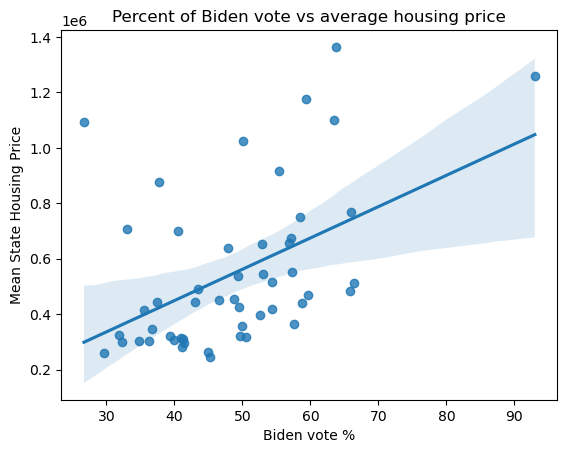

In [55]:
uniquestate_df = df[['state', 'biden_pct', "price", 'minimum_wage']]

uniquestate_df = uniquestate_df.groupby('state', as_index=False).mean()

fig = sns.regplot(data = uniquestate_df, x = 'biden_pct', y= 'price')

# Add title and labels
plt.title('Percent of Biden vote vs average housing price')
plt.xlabel('Biden vote %')
plt.ylabel('Mean State Housing Price')

Political affiliation conclusion: We see a fairly strong upward trend in our graph, indicating that the more democratic the state voted, the higher the mean state housing price. This is a very interesting result that has many societal implications regarding the political and economic sphere.

Text(0, 0.5, 'Mean State Housing Price')

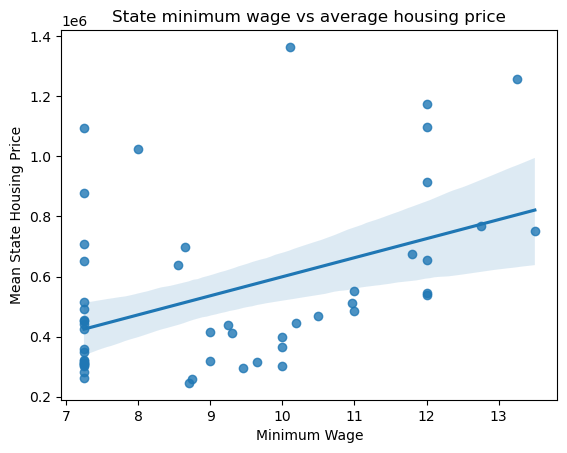

In [57]:
fig = sns.regplot(data = uniquestate_df, x = 'minimum_wage', y= 'price')

# Add title and labels
plt.title('State minimum wage vs average housing price')
plt.xlabel('Minimum Wage')
plt.ylabel('Mean State Housing Price')

Minimum Wage Conclusion: We again see a positive correlation between minimum wage and mean state housing price supported by our regression line and confidence interval, although it is slightly less strong. This means that states with higher minimum wages are slightly more likely to have higher housing prices, which does make logical sense. 

These graphs have already helped us complete part of our goal which was to investigate some creative and "outside the box" influences on housing prices! 

Now let's turn towards breaking down some of the numerical features that we think will be influential in future machine learning models based on the correlation map output. Specifically, we will investigate the trend lines of bed, bath, and house size with price. Notice that we turned off the scattering in order to not clutter the plot, and instead just use the regression line and confidence interval.

(0.0, 3599979.9999999995)

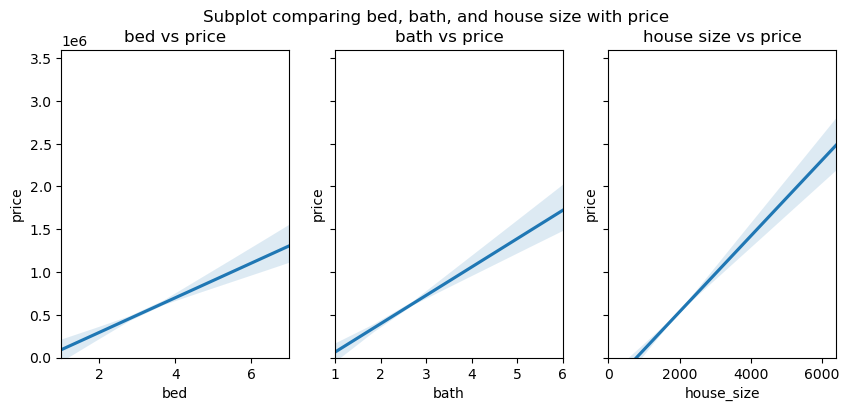

In [59]:
# create subplot
fig, ax = plt.subplots(1,3, sharey=True, figsize=(10,4))
fig.suptitle('Subplot comparing bed, bath, and house size with price')

#plot bed vs price
sns.regplot(data = df, x="bed", y="price", ax=ax[0], scatter = False)
ax[0].set_title('bed vs price')
ax[0].set_xlim(1, df['bed'].quantile(0.99))
ax[0].set_ylim(0, df['price'].quantile(0.99))

#plot bath vs price
sns.regplot(data = df, x="bath", y="price", ax=ax[1], scatter = False)
ax[1].set_title('bath vs price')
ax[1].set_xlim(1, df['bath'].quantile(0.99))
ax[1].set_ylim(0, df['price'].quantile(0.99))

#plot house size vs price
sns.regplot(data = df, x="house_size", y="price", ax=ax[2], scatter = False)
ax[2].set_title('house size vs price')
ax[2].set_xlim(0, df['house_size'].quantile(0.99))
ax[2].set_ylim(0, df['price'].quantile(0.99))

This result is about as expected from the correlation heatmap. We see that bath appears to be the most influential on price, while house size is surprisingly unimportant. This helps us conclude that bath, followed by bed variables should be more heavily useful features for our predictive machine learning models. Let's look into these two important features in a little more depth by creating a barplot that displays the average price per bedroom/bathroom quantity.

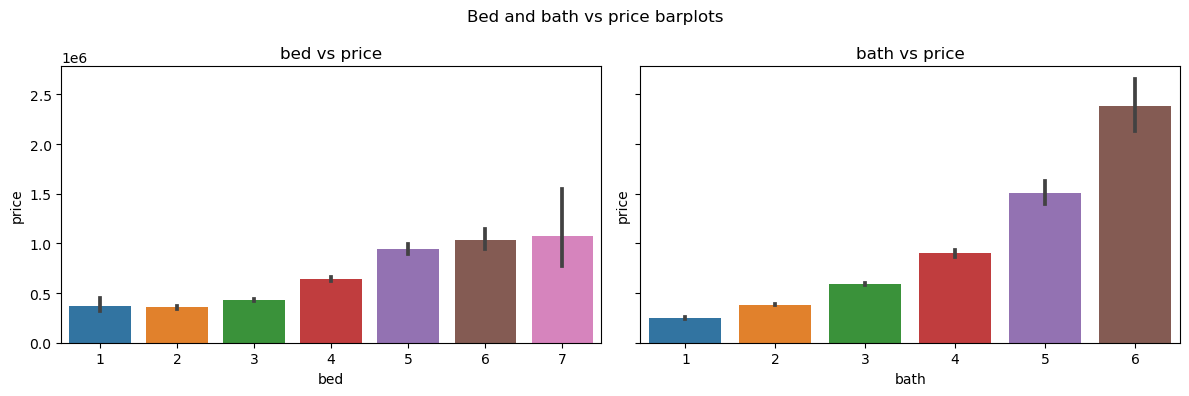

In [61]:
# prevent warnings from appearing
import warnings
warnings.filterwarnings('ignore')

#take out the upper 1% of data in order to create a cleaner visual
df_barplot = df[(df['bed'] <= df['bed'].quantile(0.99)) & (df['bath'] <= df['bath'].quantile(0.99))]

#convert to int instead of float
df_barplot['bed'] = df_barplot['bed'].astype(int)
df_barplot['bath'] = df_barplot['bath'].astype(int)

#create subplot
fig, ax = plt.subplots(1,2, sharey=True, figsize=(12,4))
fig.suptitle('Bed and bath vs price barplots')

#plot bed vs price
sns.barplot(data = df_barplot, x="bed", y="price", ax=ax[0])
ax[0].set_title('bed vs price')

#plot bath vs price
sns.barplot(data = df_barplot, x="bath", y="price", ax=ax[1])
ax[1].set_title('bath vs price')

fig.tight_layout()


Our last highly important numerical data feature to break down is the median income column. We noticed in our correlation map that it appeared one of the more influential variables, so let's get a better understanding through some visualization. First let's create a more fun, interactive map with plotly that takes a small subset of our datapoints and displays the price of the smaple vs the median income (recall measured by zipcode). We can click around by hovering over the samples to get a feel for some data points and possible relationships between the variables.

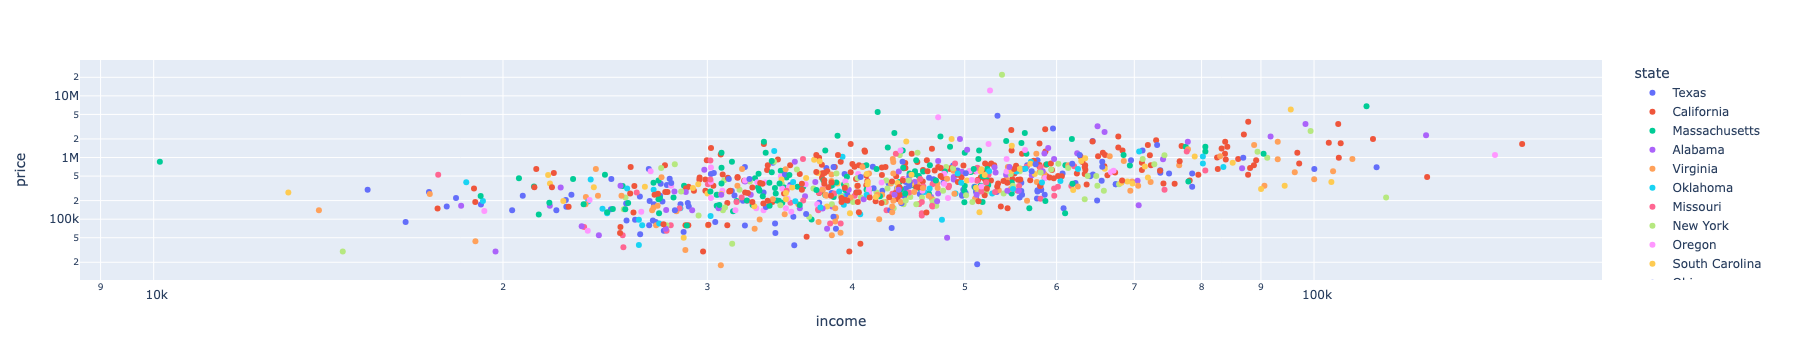

In [63]:
#create a small sampling to plot
df2 = df.sample(1000)

#create scatterplot
fig = px.scatter(df2, x="income", y="price", color="state",
           hover_name="state", log_x=True, log_y=True, size_max=60)
fig.show()

Notice there appears to be an upward trend in increasing income and increasing price, which does make logical makes. Let's see this formally using our full sample (the mini sampling was just so that we could have a reasonable ammount of scatterings that didn't clutter it). Again this time we turn off scatter and just plot the regression line.

(0.0, 5000000.0)

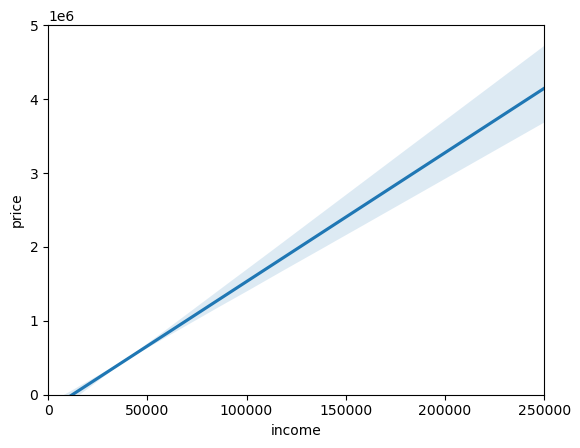

In [65]:
#select subset of dataset
uniquezip_df = df[['zip_code', 'income', "price"]]

#group by zip code to get mean income by zipcode
uniquezip_df = uniquezip_df.groupby('zip_code', as_index=False).mean()

#create plot
fig = sns.regplot(data = uniquezip_df, x = 'income', y= 'price', scatter = False)
fig.set_xlim(0, 250000)
fig.set_ylim(0, 5000000)

Our resultant regression line first of all has a noticeably positive slope, and second of all has a relatively tight confidence interval. This indicates that our variable of median income by zip code appears to be a nice predictor of price, and will likely become very important in informing our future machine learning models.

### Data Prep for Machine Learning Models

***Categorizing Price***

When beginning to develop a machine learning model, our first obstacle we encounter is what exactly we want to predict. We noticed that predicting the price to an exact number (as the current column does) is quite specific, so instead  we will want to predict whether any piece of real-estate is more generally expensive or cheap in a categorical fashion. The next question that follows is ***how we will quantify this "expensive" vs "cheap"***. 

Our natural thought was just categorizing the samples based on if they were on the higher half of all in our dataset vs the lowest. However, upon further analysis we realize that the state the property is in has an overwhelmingly powerful influence on this categorization. For example, we would see that practically all samples from California would fall in the upper portion of data, while a huge majority of samples from rural states will be in the lower. This provides less informative/impressive conclusions because what is considered expensive in one area may very well not be considered expensive in another. So to work around this and create a more challenging problem, we have decided to create a categorical column that contains a 1 if the property price is above the median housing price **of the state it is in**, and a 0 if the property is below this median average of its state.

To do this, we first merge data with the median housing prices by state. This data was taken from the following link: https://www.bankrate.com/real-estate/median-home-price/#how-much, and is up to date as of November 2023 (which is the same time period our real-estate data was taken from).

In [70]:
#upload data
df_med = pd.read_csv('median_prices.csv')
df_med.head()

#select state and median price columns we want
df_med = df_med[["state", "med_price"]]

#merge along state column
df = pd.merge(df, df_med, on = ["state"])
df.head()

price  bed  bath  acre_lot          city           state  zip_code  \
0  375000.0  3.0   2.0      0.25    Fort Myers         Florida   33919.0   
1  369000.0  4.0   3.0      0.05       Malvern    Pennsylvania   19355.0   
2  329900.0  2.0   3.0      0.05         Bowie        Maryland   20716.0   
3  229000.0  3.0   2.0      0.50        Sumter  South Carolina   29154.0   
4  144900.0  4.0   2.0      0.12  Battle Creek        Michigan   49015.0   

   house_size   income  biden_pct  trump_pct  minimum_wage med_price  
0      1490.0  40117.0       47.9       51.2          8.56  $405,000  
1      2088.0  83676.0       50.0       48.8          7.25  $268,100  
2      1120.0  84412.0       65.8       32.4         11.00  $395,000  
3      1706.0  38044.0       43.4       55.1          7.25  $360,800  
4      1930.0  34820.0       50.6       47.8          9.65  $238,800

Notice one more problem exists: we have a price listed in string form with dollar sign and commas. Instead we want it to be numerical in order to compare it with our current price column.

In [72]:
# Remove dollar signs and commas, then convert to integers
df['med_price'] = df['med_price'].replace({'\$': '', ',': ''}, regex=True).astype(int)

Lastly, we want to create a new column which we will call above_average. This column will contain a 1 if the price of that sample is above the median price in the state, and a 0 if it is below. We will also remove the median price column afterwards because it served its purpose, as well as the price column because the categorical variable will replace it. Otherwise, in our model we would be using price to inform "above average price" which does seem like cheating.

In [74]:
df['above_average'] = df.apply(lambda row: 1 if row['price'] > row['med_price'] else 0, axis=1)
df = df.drop(columns = ['med_price', 'price'])
df.head()

bed  bath  acre_lot          city           state  zip_code  house_size  \
0  3.0   2.0      0.25    Fort Myers         Florida   33919.0      1490.0   
1  4.0   3.0      0.05       Malvern    Pennsylvania   19355.0      2088.0   
2  2.0   3.0      0.05         Bowie        Maryland   20716.0      1120.0   
3  3.0   2.0      0.50        Sumter  South Carolina   29154.0      1706.0   
4  4.0   2.0      0.12  Battle Creek        Michigan   49015.0      1930.0   

    income  biden_pct  trump_pct  minimum_wage  above_average  
0  40117.0       47.9       51.2          8.56              0  
1  83676.0       50.0       48.8          7.25              1  
2  84412.0       65.8       32.4         11.00              0  
3  38044.0       43.4       55.1          7.25              0  
4  34820.0       50.6       47.8          9.65              0

Let's also verify that we successfully only added either a 0 or 1 in every column, so we have 2 categories.

In [76]:
df[["above_average"]].agg("nunique")

above_average    2
dtype: int64

This looks good, now let's also verify that we have approximately an even split between samples that were given 0 and 1 values to make sure our categorization worked correctly. We will display this distribution as a barplot.

In [78]:
binary_split_percentage = np.unique(df[["above_average"]], return_counts=True)[1] / len(df[["above_average"]])
print("The percentage below median price per that state is", round(binary_split_percentage[0] * 100, 2),
      "% and the percentage above median price per that state is", round(binary_split_percentage[1] * 100, 2))

The percentage below median price per that state is 55.09 % and the percentage above median price per that state is 44.91


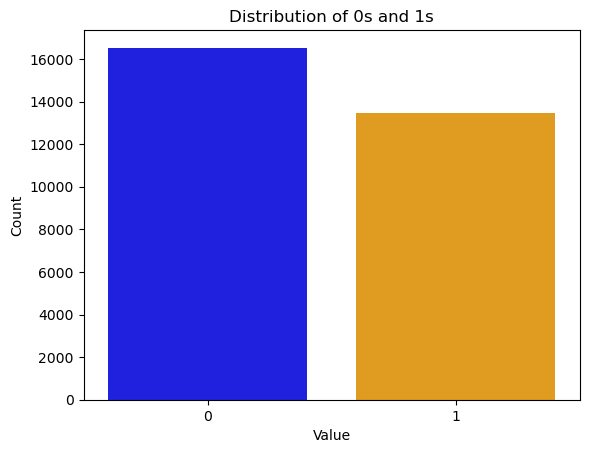

In [79]:
sns.countplot(data = df, x="above_average", palette=['blue', 'orange'])

# Add title and labels
plt.title('Distribution of 0s and 1s')
plt.xlabel('Value')
plt.ylabel('Count')

# Display the plot
plt.show()

This split seems very appropriate to use for our classification problem.

***Using only numeric data***

The next preparation challenge we encounter is that our code uses categorical, non-numerical columns such as "state" and "city", and these won't work with many dimension reduction techniques or machine learning models. So, we must assign our categorical names into binary/numeric data in order to proceed if we want to use them in our model.

To do this we first must determine which columns we need to change, meaning we need to check which columns are categorical and which are numerical.

In [83]:
# these two lists hold the columns that are numerical versus categorical
numeric = []
categoric = []

# iterate through the dataframe and sort the column into the numeric list if the type is int or float, otherwise sorting it into the categorical list.
for col in df.columns:
    if df[col].dtype == np.float64 or df[col].dtype == np.int64:
        numeric.append(col)
    else:
        categoric.append(col)

# print
print('Numeric columns:', numeric)
print('Categorical columns:', categoric)

Numeric columns: ['bed', 'bath', 'acre_lot', 'zip_code', 'house_size', 'income', 'biden_pct', 'trump_pct', 'minimum_wage', 'above_average']
Categorical columns: ['city', 'state']


After determining which columns are categorical, and therefore need to be changed to numeric values, our first attempt to manipulate these columns is to use hot encoding.

In [85]:
# create a copy of the data so that we dont affect the origional dataframe
data = df.copy()

# one hot encode categorical features that we discovered in the last cell
one_hot_encoded_data = pd.get_dummies(data, columns = ['city', 'state'])

# print our data to understand what we are working with
one_hot_encoded_data.head()


bed  bath  acre_lot  zip_code  house_size   income  biden_pct  trump_pct  \
0  3.0   2.0      0.25   33919.0      1490.0  40117.0       47.9       51.2   
1  4.0   3.0      0.05   19355.0      2088.0  83676.0       50.0       48.8   
2  2.0   3.0      0.05   20716.0      1120.0  84412.0       65.8       32.4   
3  3.0   2.0      0.50   29154.0      1706.0  38044.0       43.4       55.1   
4  4.0   2.0      0.12   49015.0      1930.0  34820.0       50.6       47.8   

   minimum_wage  above_average  ...  state_South Dakota  state_Tennessee  \
0          8.56              0  ...               False            False   
1          7.25              1  ...               False            False   
2         11.00              0  ...               False            False   
3          7.25              0  ...               False            False   
4          9.65              0  ...               False            False   

   state_Texas  state_Utah  state_Vermont  state_Virginia  state_Washington  \
0        False       False          False           False             False   
1        False       False          False           False             False   
2        False       False          False           False             False   
3        False       False          False           False             False   
4        False       False          False           False             False   

   state_West Virginia  state_Wisconsin  state_Wyoming  
0                False            False          False  
1                False            False          False  
2                False            False          False  
3                False            False          False  
4                False            False          False  

[5 rows x 6154 columns]

Above, we can see that the hot encoding has taken the two categorical columns, seperated each of the different values into their own unique column, and assigned binary(true/false) to their association with the values of other features. Even though this has done what we were interested in it accomplishing - making the categorical columns numerical - we notice that there are way too many columns so the data is very complex and has a huge input shape of thousands of features. Since this will make training a deep learning model to be extremely computationally expensive, we would perfer not to use this method.

# Dealing With Catagorical Features

We also know there are a few other methods we could use such as label encoding in order to embed categorical values such as state with numbers while maintaining the same number of columns. However, the problem with these methods is that our data is still categorical in the sense that a state as a number does not have any defining meaning based on its value. For instance, if the state California is randomly marked as a 20 and compared with a state like Georgia that is randomly marked as a 57, these numbers and the fact that 57 is greater than 20 have no numerical significance (as opposed to variables like house size where 2000 and 1000 square feet has a clear relationship). 

The benefit of the hot encoding strategy is that it would have perserved our ability to use these categorical columns, but since we saw that this would be significantly harmful to our efficiency and taht other techniques do not provide appropriate numerical data to be standardized and fitted to a model, let's explore the possibility of just not using these columns altogether.

For the purpose of future machine learning models if we want to use only "truly" numerical data this would involve losing zip code, state, and city. The great thing is, this is not really losing a ton of information because we already see these categorical variables represented in our other columns that we are keeping. For instance, our feature of income per zip code essentially quantifies the categories of zip code and city by creating a numeric measure that perserves the specific location the property is in. Additionally, the minimum wage column represents the state that the sample is from, and represents it in a meaningful numeric way that can be used by the model. Also note that the prices are normalized by average per state anyways, so the state column should not be very impactful in informing the binary choice. We conclude that we can safely remove zip code, state, and city, so that we are left with only truly numerical data to work with.

In [88]:
#drop columns zip, state, city columns
df = df.drop(columns = ['zip_code', 'state', 'city'])
df.head()

bed  bath  acre_lot  house_size   income  biden_pct  trump_pct  \
0  3.0   2.0      0.25      1490.0  40117.0       47.9       51.2   
1  4.0   3.0      0.05      2088.0  83676.0       50.0       48.8   
2  2.0   3.0      0.05      1120.0  84412.0       65.8       32.4   
3  3.0   2.0      0.50      1706.0  38044.0       43.4       55.1   
4  4.0   2.0      0.12      1930.0  34820.0       50.6       47.8   

   minimum_wage  above_average  
0          8.56              0  
1          7.25              1  
2         11.00              0  
3          7.25              0  
4          9.65              0

## Defining a Class to Handle Numerical Data

Next, since we only wish to use numerical features, we will create a class to handle the scaling of the data and the test/train split.

In [90]:
# First, creating final 'cleaned' X and y data
y_le = df['above_average']
X_le = df.drop(['above_average'], axis=1)

class CleanNumericalData:
    """
    Class that uses performs standardization and a test/train
    split on cleaned (no missing values) numerical data.
    
    Attributes:
        data: data to perform cleaning on.
        labels: labels/feature names corresponding to the data.
        test_size: proportion of data to use for the test split.
        random_state: integer controlling the 'random' shuffling 
                      to be applied to the data in the test split.
        scalar: the scalar instance to use to standardize the features.
        
    Methods:
        preprocess(): performs standardization of the features in the 
        data and performs a test/train split, creating testing and training
        datasets.
    """ 
    
    # creating initialization function
    def __init__(self, data, labels, test_size = 0.33, random_state = 42):
        self.data = data
        self.labels = labels
        self.test_size = test_size
        self.random_state = random_state
        # Using StandardScalar as scalar instance
        self.scaler = StandardScaler()
        
    # defining the preprocessing method
    def preprocess(self):
        """
        Performs standardization of the features in the data and performs 
        a test/train split, creating testing and training datasets.
        
        Returns: X_train, X_test, y_train, y_test, the testing and 
                 training sets after scaling and the random split.
        """
        # perform standardization
        self.data = self.scaler.fit_transform(self.data)

        # split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(self.data, 
                                                            self.labels, 
                                                            test_size = self.test_size, 
                                                            random_state = self.random_state)

        # return the standardized data in the correct test/train datasets
        return X_train, X_test, y_train, y_test

#### Utilizing the Data Handling Class

In [92]:
# creating an instance of the class
clean_num_data = CleanNumericalData(X_le, y_le)

# perform the split using class method
train_Xle, test_Xle, train_yle, test_yle = clean_num_data.preprocess()

In [93]:
# ensuring it worked properly
print(train_Xle[0:4])
print(test_Xle[0:4])
print(train_yle[0:4])
print(test_yle[0:4])

[[-0.26679945 -0.3786941  -0.01503631 -0.76619699 -0.6232609  -0.36414669
   0.44967744 -0.39562258]
 [ 1.11655559  1.0161815  -0.01414627  0.33239711 -0.74645063 -0.18296633
   0.23692167 -1.01540645]
 [ 0.42487807 -0.3786941  -0.01494469 -0.03406822  0.43165155  1.4023619
  -1.44272917  1.23190148]
 [ 0.42487807 -0.3786941  -0.01499705 -0.0493042  -0.88426485  1.67413245
  -1.66668262  1.58673958]]
[[-0.26679945 -0.3786941  -0.01499705 -0.45506231 -0.67252532 -0.1942901
   0.21452632  1.23190148]
 [-0.26679945 -1.0761319  -0.01507558 -0.21449426 -0.03805232  0.16807064
  -0.19978755  0.28566657]
 [-0.26679945  0.3187437  -0.01243164  0.15598054  0.9854892   0.92676343
  -0.89404323  1.23190148]
 [ 0.42487807 -0.3786941  -0.01482689 -1.21605925  1.77888155 -0.18296633
   0.23692167 -1.01540645]]
4222     0
8736     0
27882    0
27927    0
Name: above_average, dtype: int64
2308     0
22405    0
27697    1
25059    1
Name: above_average, dtype: int64


### delete below since we are using class instead

In [95]:
# # create X and y data
# y_le = df['above_average']
# X_le = df.drop(['above_average'], axis=1)

# # split into train and test sets
# #set the random state to be the same for all train test splits so we know our results are from the same data.
# train_Xle, test_Xle, train_yle, test_yle = train_test_split(X_le, y_le, test_size=0.33, random_state=42)

# # scale the numeric features using standardization
# scaler = StandardScaler()
# train_Xle = scaler.fit_transform(train_Xle)
# test_Xle = scaler.transform(test_Xle)

## Maybe remove

Label encoding further simplifies the number of columns, as the hot encoding creates too many columns to be used. In label encoding, each unique category value is assigned an integer - making our data numerical.

In [98]:
# # create the label encoder
# label_encoder = LabelEncoder()

# # create the label encoded data
# label_encoded_data = df.copy()
# label_encoded_data['state'] = label_encoder.fit_transform(label_encoded_data['state'])
# label_encoded_data['city'] = label_encoder.fit_transform(label_encoded_data['city'])

# # create X and y data
# X_le = label_encoded_data.drop(['above_average'], axis=1)
# y_le = label_encoded_data['above_average']

# # split into train and test sets
# #set the random state to be the same for all train test splits so we know our results are from the same data.
# train_Xle, test_Xle, train_yle, test_yle = train_test_split(X_le, y_le, test_size=0.33, random_state=42)

# # scale the numeric features using standardization
# scaler = StandardScaler()
# train_Xle = scaler.fit_transform(train_Xle)
# test_Xle = scaler.transform(test_Xle)

In [99]:
# # Visualise the label encoded data
# label_encoded_data

As shown above, the label encoded data is much more condensed than the hot encoded data, as each element in the categorical columns have been given a unique value.

# Feature Selection

Before feature selection, we will build a random forest classifier using the default `n_estimators = 10` (number of decision trees in the forest). This will act as a baseline to help us understand the approximate accuracy that may be achieved. 

Accuracy is:  81.48 %


<Axes: >

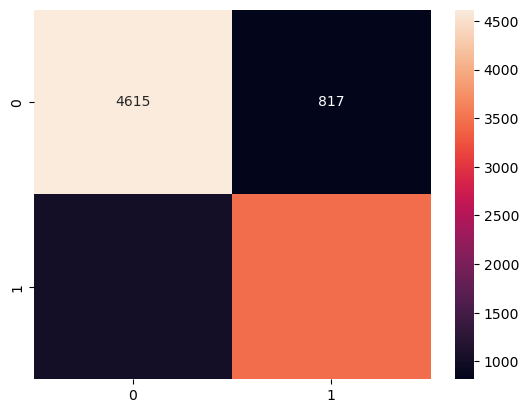

In [102]:
# Build a random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state = 43)      
clr_rf = clf_rf.fit(train_Xle, train_yle)

# calculating accuracy
ac = accuracy_score(test_yle, clf_rf.predict(test_Xle))
print('Accuracy is: ', round(ac*100, 2), "%")

# create the conf mat
cm = confusion_matrix(test_yle, clf_rf.predict(test_Xle))
sns.heatmap(cm, annot = True, fmt = "d")

From the confusion matrix, we can see that the RF classifier performs fairly well, yet it does make some errors in classification. Next, we will try feature selection methods to see if we can find more accurate results.

### Recursive Feature Elimination (RFE) with Cross-Validation and Random Forest Classification

RFE is a feature elimination selection technique that searches for a subset of key features in a training dataset that are most relavent in predicting the target variable. 

In this case, we are using a random forest classifier with 5-fold cross validation. The data will be randomly split into 5 folds, and the random forest classifier will be trained on 4 folds while the other fold is left to test the model. This is repeated 5 times and then we are able to average the testing accuracy over the 5 folds. 

Optimal number of features : 7
Best features : Index(['bed', 'bath', 'acre_lot', 'house_size', 'income', 'biden_pct',
       'trump_pct'],
      dtype='object')


Text(0, 0.5, 'Mean Test Accuracy')

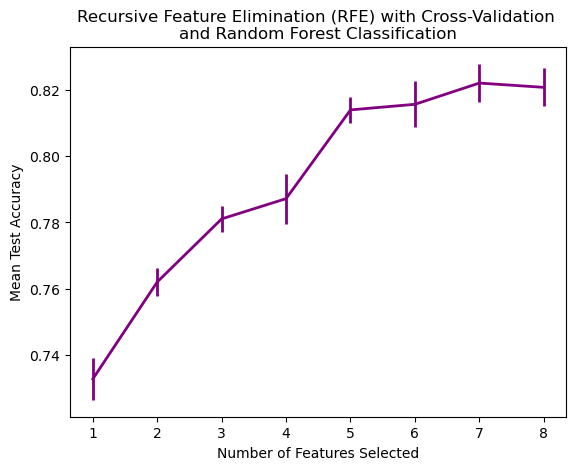

In [104]:
# creating RF classifier
clf_rf_3 = RandomForestClassifier() 
rfecv = RFECV(estimator = clf_rf_3, step = 1, cv = 5, scoring = 'accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(train_Xle, train_yle)

print('Optimal number of features :', rfecv.n_features_)

# using train_X since it is pandas df and we want .columns names
print('Best features :', X_le.columns[rfecv.support_])

# Plotting mean test accuracy calculated across cross validations with error bar
plt.errorbar(
    x = range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
    y = rfecv.cv_results_["mean_test_score"],
    yerr = rfecv.cv_results_["std_test_score"],
    color = 'purple', linewidth = 2
)

# Add title and labels
plt.title('Recursive Feature Elimination (RFE) with Cross-Validation \nand Random Forest Classification')
plt.xlabel('Number of Features Selected')
plt.ylabel('Mean Test Accuracy')

From the plot above, we can see that the optimal number of features is all 8 as the mean testing accuracy continues to increase with the addition of each one. The error bars help us visualize the error or uncertainty in the average testing aaccuracy given the number of features selected.

### Tree-Based Feature Selection in Random Forest Classification

Next, we will try tree-based feature selection in RF classification to investigate if it yields similar results. The method will also allow us to understand how the features rank compared to eachother. 

Feature ranking:
1. feature 3 (0.301714)
2. feature 4 (0.222453)
3. feature 1 (0.148778)
4. feature 2 (0.133185)
5. feature 0 (0.058761)
6. feature 6 (0.051832)
7. feature 5 (0.051804)
8. feature 7 (0.031474)


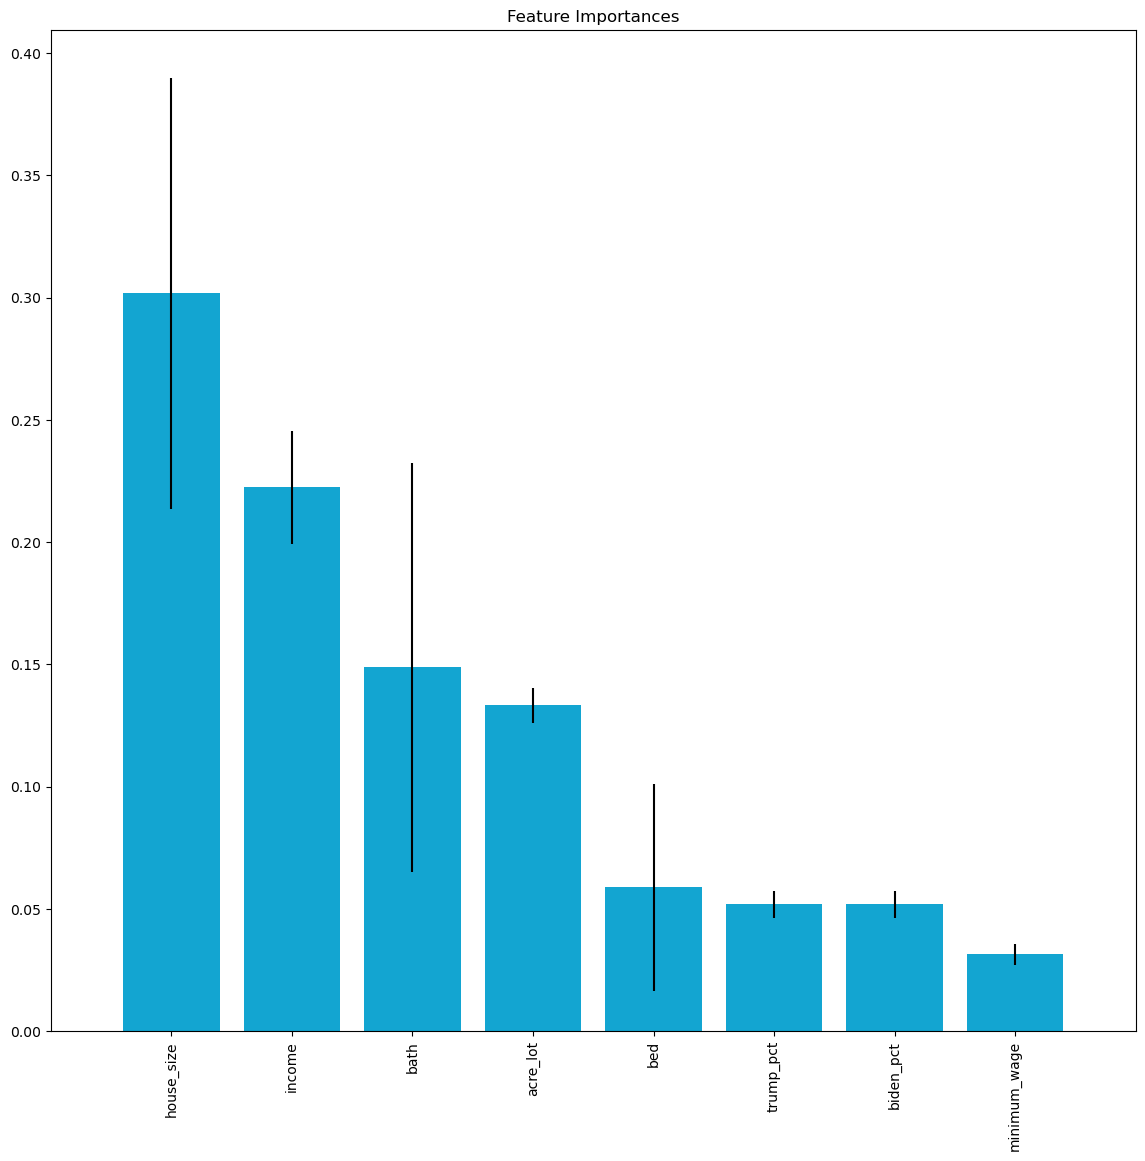

In [106]:
# creating the RF classifier
clf_rf_4 = RandomForestClassifier()      

# fitting it
clr_rf_4 = clf_rf_4.fit(train_Xle, train_yle)

# storing importances
importances = clr_rf_4.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis = 0)
indices = np.argsort(importances)[::-1]
 
# Print the feature ranking
print("Feature ranking:")
 
for f in range(train_Xle.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f],  importances[indices[f]]))

# Plot the feature importance list:
plt.figure(1, figsize = (14, 13))
plt.title("Feature Importances")
plt.bar(
    range(train_Xle.shape[1]), 
    importances[indices],
    color = "#13a5d1", yerr = std[indices], 
    align = "center"
)
plt.xticks(range(train_Xle.shape[1]), 
           X_le.columns[indices],
           rotation=90)
plt.xlim([-1, train_Xle.shape[1]])
plt.show()

The feature importance for each tree in the Random Forest, is a measure the improvement in impurity (Gini impurity or mean squared error) at each split point for a particular attribute. The average improvement over all trees for each attribute is calcuated. The higher the average improvement, the more important the feature is considered.

For reference:

In [108]:
for fet, i in enumerate(X_le.columns):
    print("feature", fet, "is", i)

feature 0 is bed
feature 1 is bath
feature 2 is acre_lot
feature 3 is house_size
feature 4 is income
feature 5 is biden_pct
feature 6 is trump_pct
feature 7 is minimum_wage


From the feature importance plot, we can see that house size is the most important feature, followed by income, number of bathrooms, and acres. The last four features in the data (number of bedrooms, biden and trump vote percentage, and minimum wage) are the least important in making accurate predictions. However, we will maintain these features in the model because of the reccommendation from the RFE with CV and RF classification algorithm above.

## Dimension Reduction

###  PCA

Dimension reduction is a commonly employed strategy before training machine learning models, so let's explore whether or not we should use it here.

In [111]:
# Call PCA command on training data
pca = PCA(n_components = 8) # creating an algorithm to conduct PCA with 8 principle components

# fit to the training data
train_Xle_pca = pca.fit_transform(train_Xle)

In [112]:
expl_var_ratio = pca.explained_variance_ratio_
cum_ratio = np.cumsum(pca.explained_variance_ratio_)

print(expl_var_ratio)
print(cum_ratio)

[4.09973734e-01 3.01785482e-01 1.16618356e-01 4.99385378e-02
 4.80151867e-02 4.63936405e-02 2.70717744e-02 2.03288483e-04]
[0.40997373 0.71175922 0.82837757 0.87831611 0.9263313  0.97272494
 0.99979671 1.        ]


Text(0, 0.5, 'Cumulative Explained Variance Ratio')

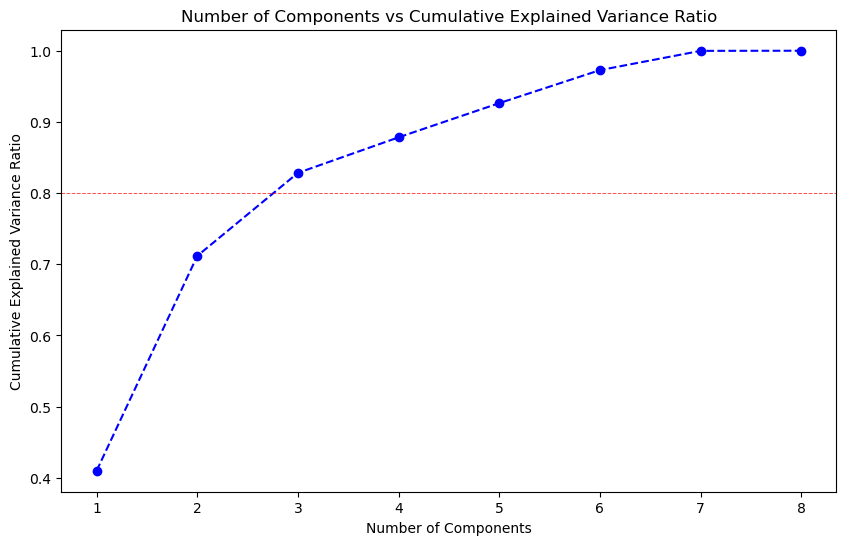

In [113]:
# Plot number of components vs cumulative explained variance ratio
plt.figure(figsize = (10, 6))
plt.plot(range(1, len(cum_ratio) + 1), cum_ratio, marker = 'o', linestyle = '--', color = 'b')

# adding horizontal line at 80% variance which should be achieved in about 4-5 components
plt.axhline(y = 0.8, color = 'r', linestyle = '--', linewidth = 0.7, alpha = 0.7) 
plt.title('Number of Components vs Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')

From the output above, we can discern that the first two components explain the most variance in the data, and by the first 4 components, the reduced dimension form of the data is able to represent about 83% of the variance in the data. 

However, given that we only start with 8 features rather than hundrend, we conclude that it is not necessary to limit our model to fewer dimensions. We noticed that when exploring models that utilize the data with restricted dimensionality, it harm our model's accuracy and does not make improvements like saving computing time. Therefore, in order to obtain a best accuracy model, it is reasonable for us to proceed with our original numerical dataframe with standardization applied.

# Machine Learning Models

Now we are ready to create some models! First, we decided to run our data through various supervised machine learning models that are used to classify data. These include: SVM, Logistic Regression, K Nearest Neighbors, Decision Tree, Random Forest, and Max Voting Classifier. Since we don't know what models will be most effective, we will take the approach of trying all of them and comparing the results. Along the same lines, as we want to optimize our models to get the highest accuracy we can get, we will employ grid search (and random search for random forest) on each model to tune our models for the highest accuracy parameters. 

We created 3 functions to run the models, cross validate the models, and create heatmaps to help visualize the accuracys based on different parameters. 

The first function takes in the model, the parameter grid we make for each individual model, and the train and test data we already split, as well as the name. Then it conducts search for best parameters (with either random search or grid search) and sets up cross validation, finding the highest preforming model. Then we fit the model on the training data and evaluate, also executing cross validation. We then evaluate this same highest preforming model with the test data and print the results.

The second function creates a heatmap that allows you to easily see the relationship between different hyperparameter values and the model's performance, heloing us to visualize which hyperparameter combinations yield the best performance. The funciton takes in the results from the evaluation function, specified columns (parameters of the model), and the title for the heatmap plot. The results inputted are organized into a pivot table, and visualized as a heatmap. 

The third function runs cross validation, outputting the mean and standard deviation of the data cross validation.

Each model is run through each sequential function, and then the test accuracy, mean cross validation accuracy, and cross validation standard deviation are appended to a list which is outputted at the end so that it was possible to compare accuracies all together.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Model: SVM
Best Parameters: {'C': 500, 'gamma': 0.1, 'kernel': 'rbf'}
Training Accuracy: 0.8058403827665949
Test Accuracy: 0.8054741945258055


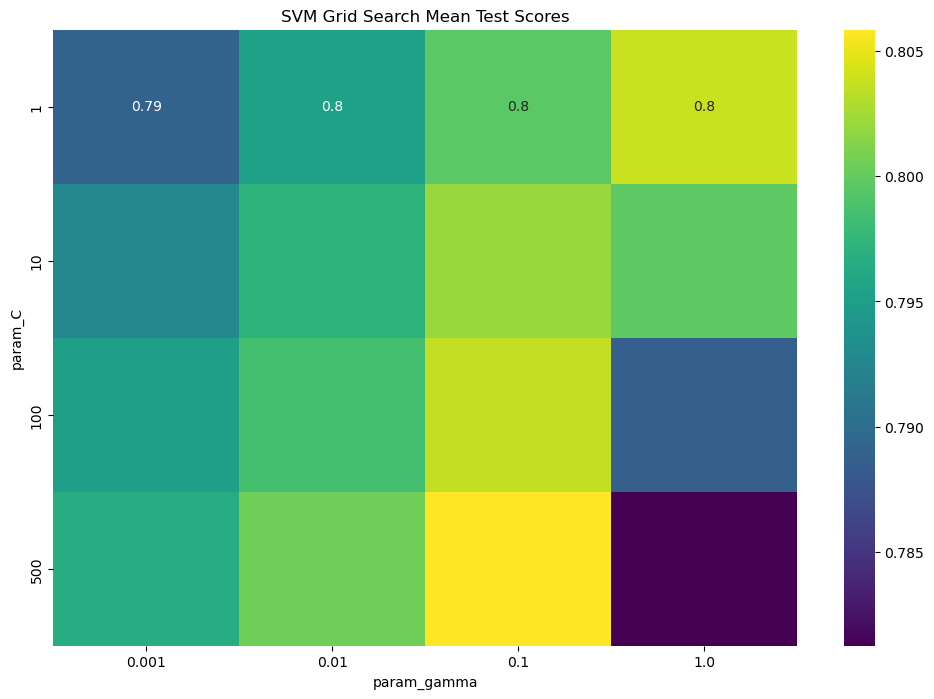

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/fionnualaeastwood/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/fionnualaeastwood/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/fionnualaeastwood/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/fionnualaeastwood/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/fionnualaeastwood/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Model: Logistic Regression (L1)
Best Parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Training Accuracy: 0.7923593546814547
Test Accuracy: 0.7913342086657913


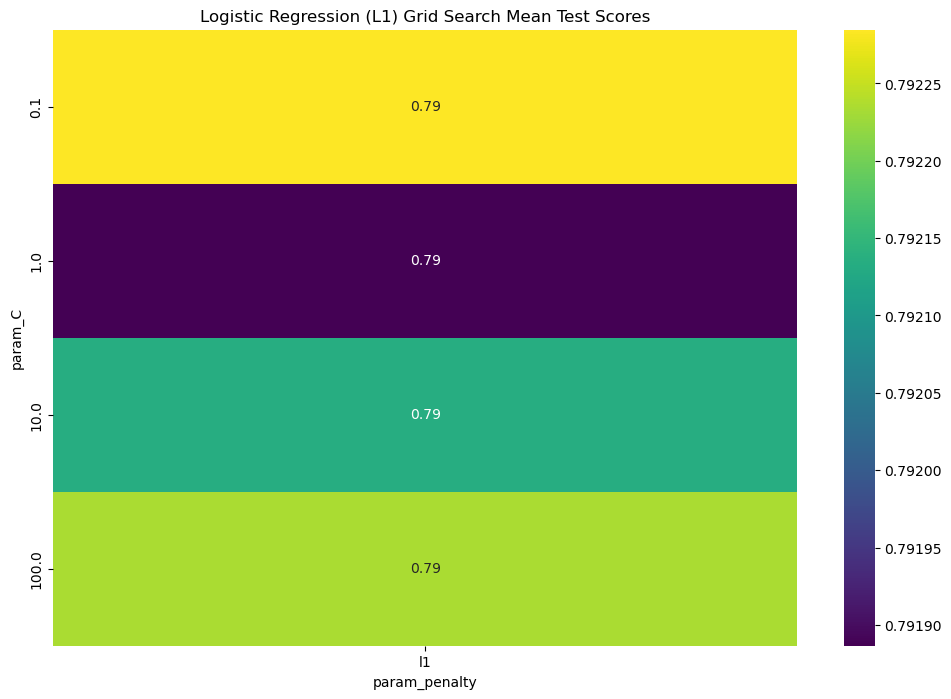

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/fionnualaeastwood/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/fionnualaeastwood/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/fionnualaeastwood/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/fionnualaeastwood/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/fionnualaeastwood/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Model: Logistic Regression (L2)
Best Parameters: {'C': 100, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Training Accuracy: 0.7924089945695547
Test Accuracy: 0.7916372083627916


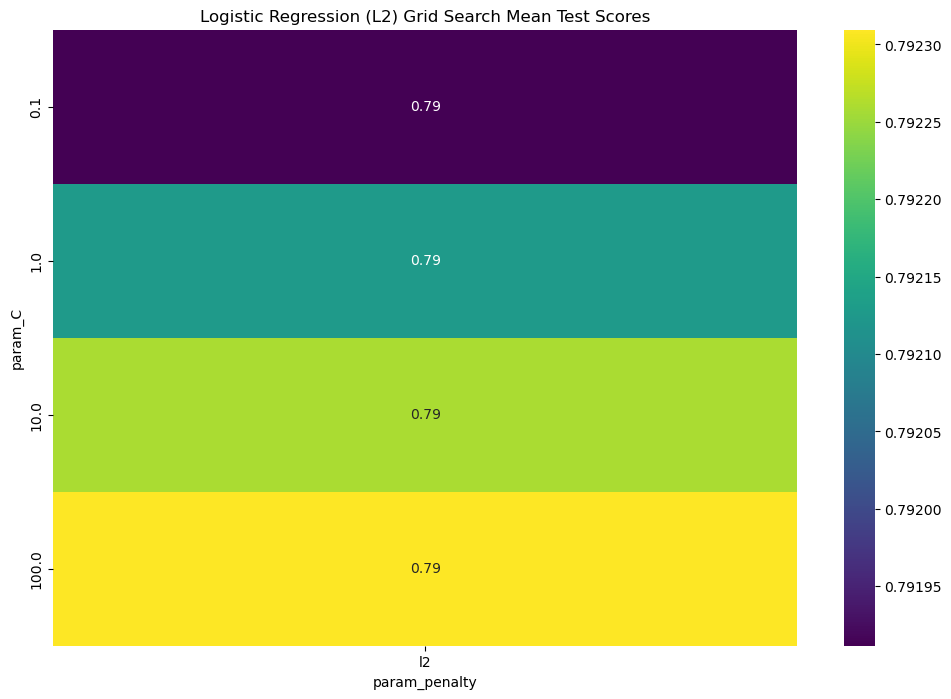

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Model: KNN
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 30, 'weights': 'distance'}
Training Accuracy: 0.8050943739398011
Test Accuracy: 0.8026461973538026


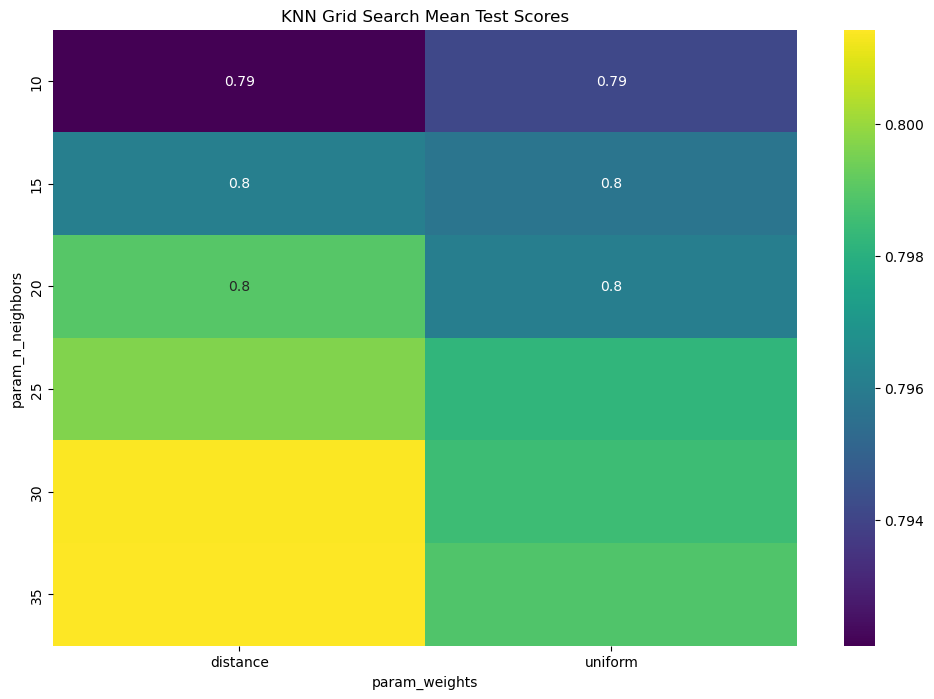

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Model: Decision Tree
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt'}
Training Accuracy: 0.7891753493165854
Test Accuracy: 0.7842642157357843


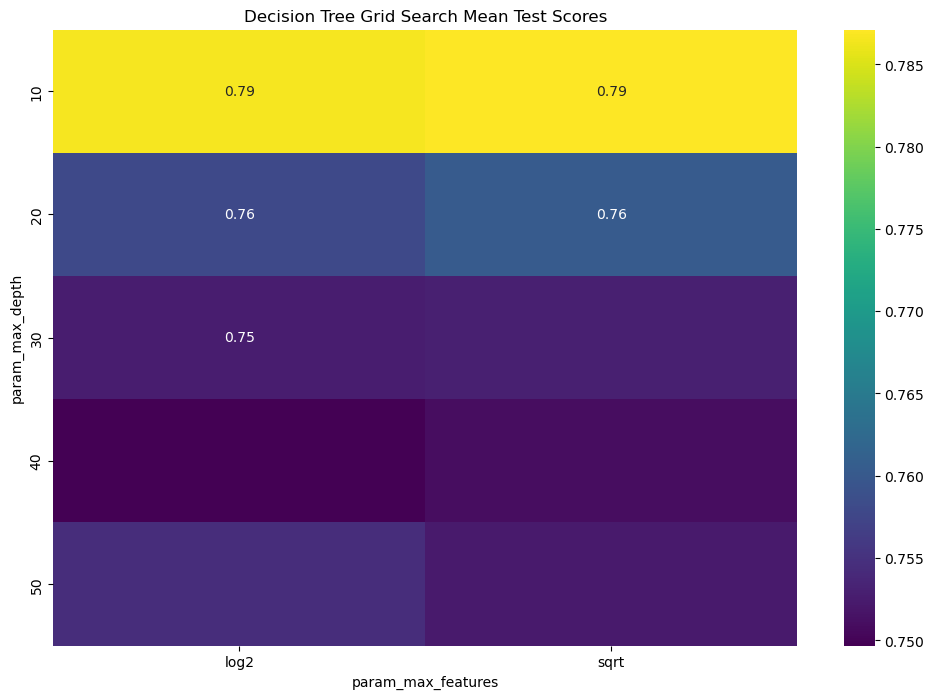

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Model: Random Forest
Best Parameters: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'entropy'}
Training Accuracy: 0.8235004163465192
Test Accuracy: 0.8175941824058176


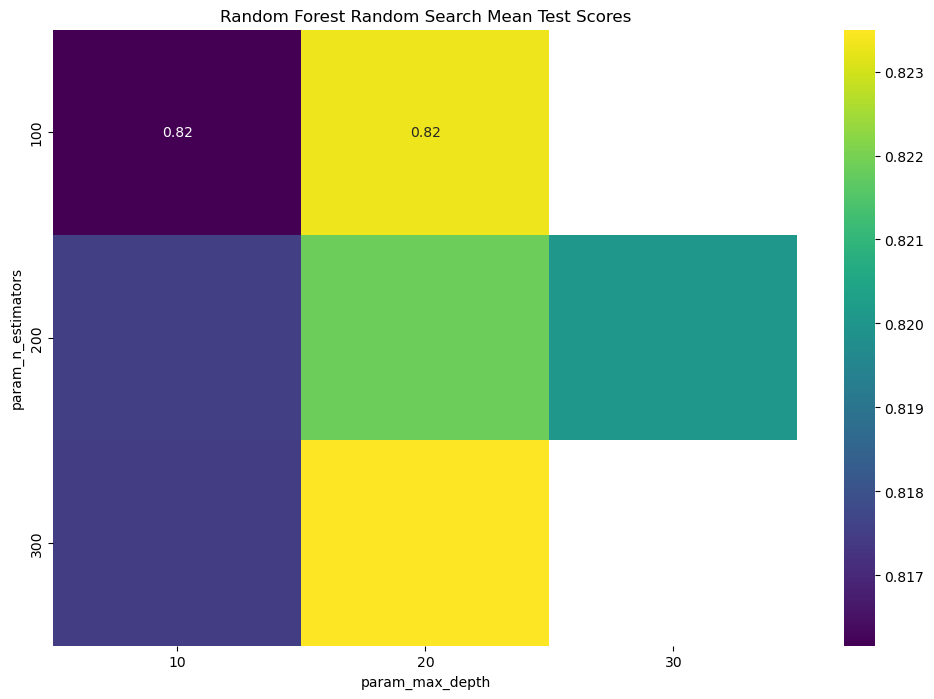

Voting Classifier Test Set Accuracy: 0.8093121906878094

Model Test Accuracies:
SVM: Test Accuracy = 0.8054741945258055, CV Mean Accuracy = 0.8058403827665949, CV Std = 0.0047717621311462515
Logistic Regression: Test Accuracy = 0.7916372083627916, CV Mean Accuracy = 0.7924089945695547, CV Std = 0.00404110389842598
KNN: Test Accuracy = 0.8026461973538026, CV Mean Accuracy = 0.8050943739398011, CV Std = 0.004894597388813586
Decision Tree: Test Accuracy = 0.7842642157357843, CV Mean Accuracy = 0.7844995366366377, CV Std = 0.005780038974855344
Random Forest: Test Accuracy = 0.8175941824058176, CV Mean Accuracy = 0.823649818552104, CV Std = 0.006445975583120614
Voting Classifier: Test Accuracy = 0.8093121906878094, CV Mean Accuracy = 0.8112627857974489, CV Std = 0.005038919496424406


In [117]:

# functions for executing models
def evaluate_models(model, param_grid, train_X, train_y, test_X, test_y, model_name):
    """
    This function runs a search to find optimal parameters and execute cross validation, and evaluates the best model on training and testing data.
    inputs: Model being used, unique paramater grid for that model, training and testing data, and the models name
    outputs: Dataframe of cross validation results, best model, and test accuracy
    """
    # set model paramaters using search engine, and set up cross validation (cv is how many cross validation folds)
    if model_name == "Random Forest":
        search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
    else:
        search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
        
    # Fit the grid search
    search.fit(train_X, train_y)
    
    # Get the best parameters and best score
    best_params = search.best_params_ # find best parameters
    best_score = search.best_score_ # find the best cross validation score
    
    # Evaluate on the test data
    best_model = search.best_estimator_ # find model that preformed the best during hyperparameter search
    test_accuracy = best_model.score(test_X, test_y) # evaluate best model based on test data
    
    # print parameters and scores
    print(f"Model: {model_name}")
    print(f"Best Parameters: {best_params}")
    print(f"Training Accuracy: {best_score}")
    print(f"Test Accuracy: {test_accuracy}")
    
    results = pd.DataFrame(search.cv_results_) # set dataframe to hold cross validation results
    
    return results, best_model, test_accuracy

# function to print heatmap
def plot_heatmap(results, pivot_index, pivot_columns, title):
    """
    This function creates a heatmap that allows you to easily see the relationship between different hyperparameter values and the model's performance, showing 
    which hyperparameter combinations yield the best performance.
    input: This funciton takes in the results from the evaluation function, specified columns (parameters of the model), and the title for the heatmap plot.
    output: This function takes the results from a hyperparameter search, organizes them into a pivot table, and visualizes the results as a heatmap.
    """
    pivot_table = results.pivot_table(values='mean_test_score', index=pivot_index, columns=pivot_columns) # create a pivot table
    plt.figure(figsize=(12, 8)) # deliniate the figure space
    sns.heatmap(pivot_table, annot=True, cmap='viridis') # plot the heatmap
    
    # add title, labeling, and present the finished plot
    plt.title(title)
    plt.xlabel(pivot_columns)
    plt.ylabel(pivot_index)
    plt.show()

# function to cross validate the model
def cross_validate_model(model, X, y):
    """
    This function generates the mean and standard deviation of the data cross validation.
    inputs: This function takes in the machine learning model to be evaluated, X-features of the dataset, adn the y-labels of the dataset.
    outputs: The mean and standard deviation of the cross-validation scores.
    """
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy') # complete cross validation with 5 folds
    
    # find and return the mean and standard deviation of the cross validated scores
    return cv_scores.mean(), cv_scores.std()

# holds accuracies to hold accuracies from all models
accuracies = []

# SVM
# make param grid for search
svm_param_grid = {'C': [1, 10, 100, 500], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}
# run evaluation function and plot heatmap
svm_results, svm_best_model, svm_test_accuracy = evaluate_models(SVC(), svm_param_grid, train_Xle, train_yle, test_Xle, test_yle, "SVM")
plot_heatmap(svm_results, 'param_C', 'param_gamma', 'SVM Grid Search Mean Test Scores')
# run cross validation function
svm_cv_mean, svm_cv_std = cross_validate_model(svm_best_model, train_Xle, train_yle)
# append test accuracy, mean cross validation accuracy, and cross validation standard deviation to list
accuracies.append(('SVM', svm_test_accuracy, svm_cv_mean, svm_cv_std))

# Logistic Regression
# make param grid for search
log_param_grid_l1 = {'C': [0.1, 1, 10, 100], 'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'max_iter': [1000]}
log_param_grid_l2 = {'C': [0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['liblinear', 'saga', 'newton-cg'], 'max_iter': [1000]}
# run evaluation function and plot heatmap for l1
log_results_l1, log_best_model_l1, log_test_accuracy_l1 = evaluate_models(LogisticRegression(), log_param_grid_l1, train_Xle, train_yle, test_Xle, test_yle, "Logistic Regression (L1)")
plot_heatmap(log_results_l1, 'param_C', 'param_penalty', 'Logistic Regression (L1) Grid Search Mean Test Scores')
# run evaluation function and plot heatmap for l2
log_results_l2, log_best_model_l2, log_test_accuracy_l2 = evaluate_models(LogisticRegression(), log_param_grid_l2, train_Xle, train_yle, test_Xle, test_yle, "Logistic Regression (L2)")
plot_heatmap(log_results_l2, 'param_C', 'param_penalty', 'Logistic Regression (L2) Grid Search Mean Test Scores')

# Choose the best logistic regression model between L1 and L2
if log_test_accuracy_l1 > log_test_accuracy_l2:
    log_best_model = log_best_model_l1
    log_test_accuracy = log_test_accuracy_l1
    log_results = log_results_l1
else:
    log_best_model = log_best_model_l2
    log_test_accuracy = log_test_accuracy_l2
    log_results = log_results_l2

# run cross validation and append test accuracy, mean cross validation accuracy, and cross validation standard deviation to list
log_cv_mean, log_cv_std = cross_validate_model(log_best_model, train_Xle, train_yle)
accuracies.append(('Logistic Regression', log_test_accuracy, log_cv_mean, log_cv_std))

# KNN
# make param grid for search
knn_param_grid = {'n_neighbors': range(10, 40, 5), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan', 'minkowski']}
# run evaluation function and plot heatmap
knn_results, knn_best_model, knn_test_accuracy = evaluate_models(KNeighborsClassifier(), knn_param_grid, train_Xle, train_yle, test_Xle, test_yle, "KNN")
plot_heatmap(knn_results, 'param_n_neighbors', 'param_weights', 'KNN Grid Search Mean Test Scores')
# run cross validation and append test accuracy, mean cross validation accuracy, and cross validation standard deviation to list
knn_cv_mean, knn_cv_std = cross_validate_model(knn_best_model, train_Xle, train_yle)
accuracies.append(('KNN', knn_test_accuracy, knn_cv_mean, knn_cv_std))

# Decision Tree
# make param grid for search
tree_param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50], 'max_features': [None, 'sqrt', 'log2']}
# run evaluation function and plot heatmap
tree_results, tree_best_model, tree_test_accuracy = evaluate_models(DecisionTreeClassifier(), tree_param_grid, train_Xle, train_yle, test_Xle, test_yle, "Decision Tree")
plot_heatmap(tree_results, 'param_max_depth', 'param_max_features', 'Decision Tree Grid Search Mean Test Scores')
# run cross validation and append test accuracy, mean cross validation accuracy, and cross validation standard deviation to list
tree_cv_mean, tree_cv_std = cross_validate_model(tree_best_model, train_Xle, train_yle)
accuracies.append(('Decision Tree', tree_test_accuracy, tree_cv_mean, tree_cv_std))

# Random Forest
# make param grid for search
rf_param_grid = {'n_estimators': [100, 200, 300], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30], 'max_features': ['sqrt', 'log2']}
# run evaluation function and plot heatmap
rf_results, rf_best_model, rf_test_accuracy = evaluate_models(RandomForestClassifier(), rf_param_grid, train_Xle, train_yle, test_Xle, test_yle, "Random Forest")
plot_heatmap(rf_results, 'param_n_estimators', 'param_max_depth', 'Random Forest Random Search Mean Test Scores')
# run cross validation and append test accuracy, mean cross validation accuracy, and cross validation standard deviation to list
rf_cv_mean, rf_cv_std = cross_validate_model(rf_best_model, train_Xle, train_yle)
accuracies.append(('Random Forest', rf_test_accuracy, rf_cv_mean, rf_cv_std))

# Voting Classifier
# make voiting classifer model with all models previously used
voting_clf = VotingClassifier(estimators=[
    ('knn', knn_best_model),
    ('logistic', log_best_model),
    ('tree', tree_best_model),
    ('rf', rf_best_model)
], voting='hard')

# fit with training data
voting_clf.fit(train_Xle, train_yle)
# find accuracy
voting_test_accuracy = voting_clf.score(test_Xle, test_yle)
# run cross validation and append test accuracy, mean cross validation accuracy, and cross validation standard deviation to list
voting_cv_mean, voting_cv_std = cross_validate_model(voting_clf, train_Xle, train_yle)
print(f"Voting Classifier Test Set Accuracy: {voting_test_accuracy}")
accuracies.append(('Voting Classifier', voting_test_accuracy, voting_cv_mean, voting_cv_std))

# Print all model accuracies
print("\nModel Test Accuracies:")
for model_name, test_accuracy, cv_mean, cv_std in accuracies:
    print(f"{model_name}: Test Accuracy = {test_accuracy}, CV Mean Accuracy = {cv_mean}, CV Std = {cv_std}")


According to the collection of accuracies we have all together here, and the models run above, the Random Forest Model has the highest testing accuracy.

## Discussion of these origional models

## Fully Connected Neural Networks (NN)

For our NN, we will use tensorflow Keras sequential models.

For the imitial model, we decided to make it very simple to establish a baseline of how well even a simple model can perform when making predictions on the data. 

**Layers**
- Input neurons: 8 (8 features)
- Hidden layer 1: 6 neurons
    - This small amount was selected using the 'rule of thumb' method, which states the number of hidden neurons should be between the size of the input layer (8) and the output layer (1)
- Dropout layer: p = 0.2 
    - The initial dropout value is 0.2 and will be altered to something between 0.2 - 0.5 as needed to help with overfitting
- Output layer: 1 (binary 0 or 1 for above or below median price for that state)

**Hyperparameters for the Hidden Layers**
- activation = 'relu' selected as an initial activation function
- kernel_initializer = "he_normal" selected since it tends to pair effectively with reLU activation
- loss: binary crossentropy 
- optimizer = 'adam' was selected for its general success on other models and wide utilization
- metrics: accuracy
- epochs = 50; our machines had the ability and efficinecy to run a larger number, which will hopefully help decrease the training loss
- batch_size = 32 selected as a starting point

### Defining a Class to Create NN Models

We first defined a class to help with the creation, compilation, and training of NN models.

In [121]:
class CreateNN:
    """
    A class that constructs, compiles, and trains NN models.
    
    Attributes:
        input_dim: the number of input features.
        num_classes: the number of output classes.
        hidden_layers: a list containing the number of units in 
                       each hidden layer. 
        dropout_rate: the dropout rate for the dropout layer.
        activation: the activation function to use in the 
                    hidden layers.
        kernel_initializer: the kernel initializer to use.
        model: the type of NN model to create (default is the Keras
               Sequential model).
               
    Methods:
        build_model(): constructs the NN model.
        compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']): 
            Compiles the neural network model with specified optimizer, loss, and metrics.
        train(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2): Trains 
            the neural network model on the training data and uses some data for 
            validation.
        plot_history(history): plots the training and validation history of a model.
        print_metrics(history): prints the final training and validation metrics.
    """
    
    # creating the initialization function
    def __init__(self, input_dim, num_classes, hidden_layers = [6], dropout_rate = 0.2, activation = 'relu', kernel_initializer = 'he_normal'):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.hidden_layers = hidden_layers
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.kernel_initializer = kernel_initializer
        self.model = self.build_model()
        
    def build_model(self):
        """
        Constructs a NN model. 
        
        Returns a Sequential NN model. 
        """
        # creating the model
        model = tf.keras.Sequential()
        
        # adding the first hidden layer
        model.add(Dense(self.hidden_layers[0], 
                        activation = self.activation, 
                        kernel_initializer = self.kernel_initializer, 
                        input_shape = (self.input_dim,)))
        
        # Iterating through possible additional hidden layers
        for units in self.hidden_layers[1:]:
            # adding additional hidden layers
            model.add(Dense(
                units, 
                activation = self.activation, 
                kernel_initializer = self.kernel_initializer
            ))
        
        # adding a dropout layer
        model.add(Dropout(self.dropout_rate))
        
        
        model.add(Dense(self.num_classes))
        return model
    
    def compile(self, optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy']):
        """
        Compiles the NN model with specified optimizer, loss, and metrics.
        
        Arguments:
            optimizer: the optimizer to use for training (default = "adam").
            loss: the loss function to use for training (default is binary crossentropy).
            metrics: the list of metrics to be evaluated by the model during 
                     training and testing.
        """
        
        # compiling the model
        self.model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
        
    def fit(self, X_train, y_train, epochs = 20, batch_size = 32, validation_data = None, verbose = 0):
        """ 
        Trains the neural network model on the training data and some of the data for 
        validation.

        Arguments:
            X_train: training input data.
            y_train: training labels.
            epochs (default = 20): number of epochs to train the model.
            batch_size (default = 32): number of samples per gradient update.
            validation_data (default = None): the data on which to evaluate the loss 
                                              and any model metrics at the end of each 
                                              epoch.
            verbose (default = 0): setting silent verbosity.

        Returns: A history record of training loss values and metrics values at successive 
                 epochs.
        """

        # Fitting the model
        history = self.model.fit(X_train, y_train, 
                                 epochs = epochs, 
                                 batch_size = batch_size, 
                                 validation_data = validation_data, 
                                 verbose = verbose)
        return history
    
    def plot_history(self, history):
        """
        A function that plots the training and validation metrics of a NN.

        Arguments:
            history: the history of training loss values and metrics values 
                     at successive epochs.
        """
        # creating a figure and axes
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        # Plotting training and validation loss
        ax1.plot(history.history['loss'], label='Training Loss', color='blue')
        ax1.plot(history.history['val_loss'], label='Validation Loss', color='purple')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()

        # Plotting training and validation accuracy
        ax2.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
        ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='purple')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()

        # Setting a common title for the plots
        fig.suptitle('Training and Validation Metrics', fontsize=16)

        # Show the plots
        plt.show()
        
    def print_metrics(self, history):
        """
        Prints the final training and validation metrics.
        
        Arguments:
            history: the history of training loss values and metrics values 
                     at successive epochs.
        """
        # Print training metrics
        print("Training Accuracy:", round(history.history['accuracy'][-1] * 100, 2), "%")
        print("Training Loss:", round(history.history['loss'][-1], 2))
        
        # Print validation metrics if available
        if 'val_accuracy' in history.history:
            print("Validation Accuracy:", round(history.history['val_accuracy'][-1] * 100, 2), "%")
            print("Validation Loss:", round(history.history['val_loss'][-1], 2))

#### Splitting Training Data to Create Validation Data

Before creating models with the training data, we will split it into training (80%) and validation (20%) so we can monitor the performance of the model to adjust hyperparameters and detect any overfitting.

In [123]:
# train_Xle and train_yle are the training data
# Splitting some data for validation
train_X_NN, val_X_NN, train_y_NN, val_y_NN = train_test_split(train_Xle, train_yle, 
                                                              test_size = 0.2, random_state = 555)

#### Creating an Initial "Baseline" Model (Model 1)

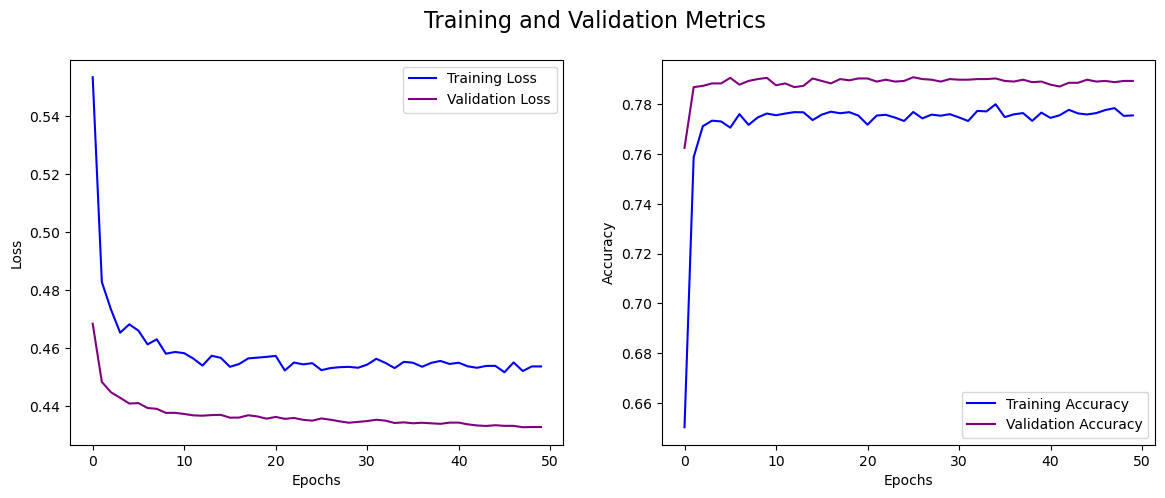

In [125]:
# creating an instance of the class
model_1 = CreateNN(
    input_dim = train_Xle.shape[1],
    num_classes = 1, 
    hidden_layers = [6], # 1 hidden layer, 6 neurons
    dropout_rate = 0.2
)

# compiling the model
model_1.compile()

# Fitting the model
model_1_hist = model_1.fit(
    train_X_NN, train_y_NN, 
    epochs = 50, batch_size = 32, 
    validation_data = (val_X_NN, val_y_NN),
    verbose = 0
)

# Plotting the training and validation metrics
model_1.plot_history(model_1_hist)

In [126]:
# Printing the final training and validation metrics
model_1.print_metrics(model_1_hist)

Training Accuracy: 77.55 %
Training Loss: 0.45
Validation Accuracy: 78.94 %
Validation Loss: 0.43


From the plots above, we can see that the loss levels out so we will leave the number of epochs as is. The loss steadily decreases over the epochs and plateaus at 0.456 (training) and 0.43 (validation). 

The achieved training accuracy is 76.74 % and the validation Accuracy: 79.71 %. Since these are similar, it is reasonable to say that the model is not prone to overfitting, but we will compare with the testing accuracy to confirm. 

**Evaluating Model 1 on the Testing Data**

In [128]:
test_loss, test_accuracy = model_1.model.evaluate(test_Xle, test_yle, verbose = 0)

# Print the testing accuracy and loss
print("Testing Accuracy:", round(test_accuracy*100, 2), "%")
print("Testing Loss:", round(test_loss, 2))

Testing Accuracy: 78.08 %
Testing Loss: 0.44


As suspected, the testing accuracy of 79.18 is similar to the training and validation accuracies, suggesting no changes to the dropout value need to be made since overfitting is not an issue. 

## NN Hyperparameter Search

To do a more robust search to tune the hyperparameters of the NN- including how many layers to use, the number of neurons for each layer, batch size, and activation function- we will create a function that uses 'adam' optimizer 
with 'binary_crossentropy' loss function and 'accuracy' as the metric by default to compiled Keras sequential models created for binary classification. These models will test unique combinations of the hyperparameters we want to tune in order to see which is optimal. **GridSearchCV** will be applied to all the layers, activation functions, and batch sizes we want to test.

In [130]:
def create_model(layers, activation):
    """
    Creates Keras sequential models given the number of layers and 
    activation function given in the input. Uses 'adam' optimizer 
    and 'binary_crossentropy' loss function, and 'accuracy' as the 
    metric by default. 
    
    Args:
        layers: list of lists with length of the list representing
                the number of hidden layers and each element of the 
                list representing the number of neurons for each layer.
        activation: string representing the activation functionto 
                    use.
        
    Returns the compiled Keras sequential model created for binary 
    classification.
    """
    
    # defining sequential model
    model = tf.keras.Sequential()
    
    # Iterating through layers
    for i, nodes in enumerate(layers):
        # If 1 layer given
        if i == 0:
            # 1 hidden layer
            model.add(Dense(nodes, input_dim = train_Xle.shape[1], kernel_initializer = "he_normal"))
            model.add(Activation(activation))
        
        # Adding more dense layers depending on the input
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
        
        # Adding dropout layer before output to help with overfitting
        model.add(Dropout(0.2))
        
        # Output layer
        model.add(Dense(1))
        
        # Compiling the model
        model.compile(
            loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
            optimizer = 'adam',
            metrics = ['accuracy']
        )
        
        return model

In [131]:
# setting a seed for reproducability 
tf.random.set_seed(555)

# Creating & compiling the model
model = KerasClassifier(build_fn = create_model, activation='relu', layers = 6, verbose = 0)
model

KerasClassifier(
	model=None
	build_fn=<function create_model at 0x19072d580>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	activation=relu
	layers=6
	class_weight=None
)

In [132]:
#prevent long warning string from appearing
warnings.filterwarnings('ignore')

# defining layers and activation functions to test
layers = [[6], [6, 32], [6, 64, 32], [6, 64, 128, 64]]
activations = ['sigmoid', 'relu']

# defining a parameter search grid
param_grid = dict(
    layers = layers, 
    activation = activations, 
    batch_size = [16, 32], 
    epochs = [50]
)
grid = GridSearchCV(
    estimator = model, 
    param_grid = param_grid
)

In [133]:
# Fitting models with the unique combinations of hyperparameters given the testing criteria
grid_results = grid.fit(train_Xle, train_yle)

[CV 1/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.803 total time=  24.9s
[CV 2/5] END .........C=10, gamma=1, kernel=rbf;, score=0.794 total time=  28.7s
[CV 3/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.805 total time=  22.6s
[CV 5/5] END ........C=100, gamma=1, kernel=rbf;, score=0.786 total time= 1.3min
[CV 1/5] END .....C=500, gamma=0.01, kernel=rbf;, score=0.801 total time=  42.9s
[CV 3/5] END .....C=500, gamma=0.01, kernel=rbf;, score=0.808 total time=  36.6s
[CV 3/5] END ....C=500, gamma=0.001, kernel=rbf;, score=0.801 total time=  25.7s
[CV 1/5] END C=0.1, max_iter=1000, penalty=l1, solver=saga;, score=0.790 total time=   1.9s
[CV 3/5] END C=10, max_iter=1000, penalty=l1, solver=liblinear;, score=0.799 total time=   1.1s
[CV 4/5] END C=10, max_iter=1000, penalty=l1, solver=saga;, score=0.794 total time=   6.5s
[CV 2/5] END C=0.1, max_iter=1000, penalty=l2, solver=newton-cg;, score=0.786 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=1000, penalty=l2, solver=new

**Best Model According to GridSearchCV**

In [135]:
# Getting best model
[grid_results.best_score_, grid_results.best_params_]

[0.7889763814600215,
 {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'layers': [6, 32]}]

After running model iterations with deeper and wider NN, the deepest NN model with 4 hidden layers containing 6, 64, 128, and 64 neurons was selected as the optimal model. It achieved a training accuracy of about 78% with hyperparameters:

- 'activation': 'relu'
- 'batch_size': 16
- 'epochs': 50

### Creating the 'Best' NN Model

Using the results from GridSearchCV, we will create the 'best' NN model using the optimized parameters.

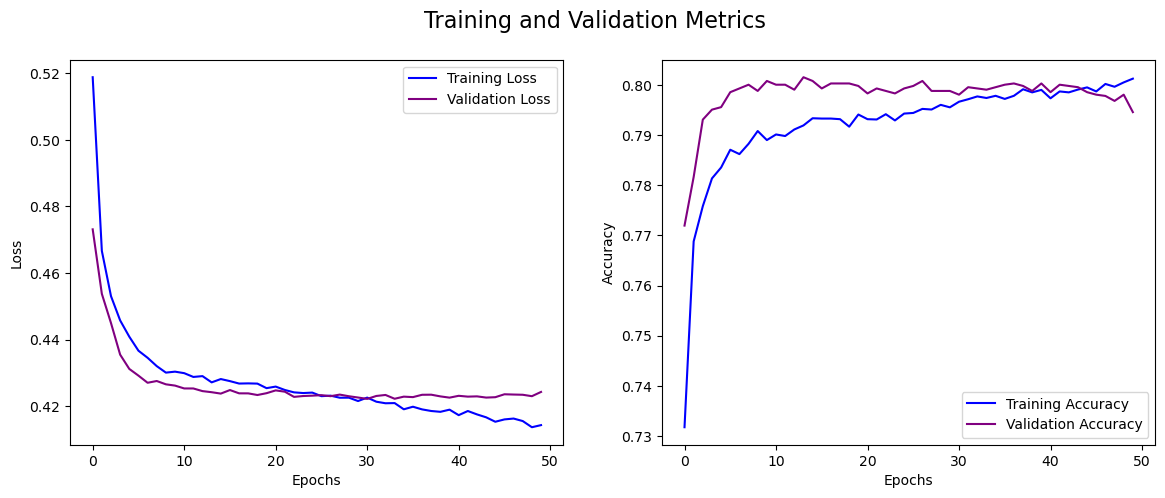

In [138]:
# creating an instance of the class
model_best = CreateNN(
    input_dim = train_Xle.shape[1],
    num_classes = 1, 
    hidden_layers = [6, 64, 128, 64], # 1 hidden layer, 6 neurons
    dropout_rate = 0.2
)

# compiling the model
model_best.compile()

# Fitting the model
model_best_hist = model_best.fit(
    train_X_NN, train_y_NN, 
    epochs = 50, batch_size = 32, 
    validation_data = (val_X_NN, val_y_NN),
    verbose = 0
)

# Plotting the training and validation metrics
model_best.plot_history(model_best_hist)

In [139]:
# Printing the final training and validation metrics
model_best.print_metrics(model_best_hist)

Training Accuracy: 80.13 %
Training Loss: 0.41
Validation Accuracy: 79.46 %
Validation Loss: 0.42


From the plots above, we can see that the loss levels out close to 50 epochs. The loss steadily decreases over the epochs and plateaus at 0.43 (training) and 0.43 (validation).

The achieved training accuracy is 78.95 % and the validation accuracy is slightly better at 79.56 %

#### Evaluating 'Best' NN Model on the Testing Data

In [141]:
best_test_loss, best_test_accuracy = model_best.model.evaluate(test_Xle, test_yle, verbose = 0)

# Print the testing accuracy and loss
print("Testing Accuracy:", round(best_test_accuracy*100, 2), "%")
print("Testing Loss:", round(best_test_loss, 2))

Testing Accuracy: 79.41 %
Testing Loss: 0.44


For the 'best' NN model, the testing accuracy of 79.39, which is similar to the validation accuracy, and slightly better than the training accuracy.

Next, we will visualize the classifications the model makes.

<Axes: >

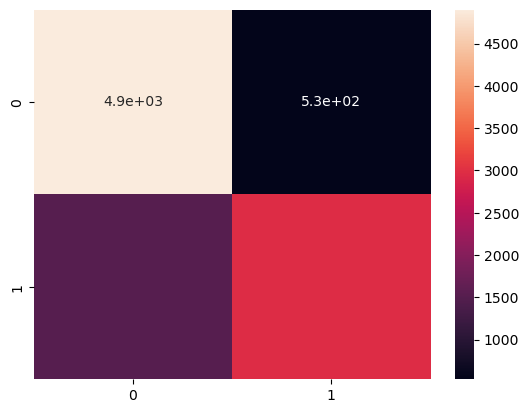

In [143]:
## Visualizing
# predicting the test set results
y_preds_best = model_best.model.predict(test_Xle, verbose = 0)
y_preds_best = (y_preds_best > 0.5)

# Making the confusion matrix 
conf_mat_best = confusion_matrix(test_yle, y_preds_best)
sns.heatmap(conf_mat_best, annot = True)

In [144]:
# Creating a classification report
class_report = classification_report(test_yle, y_preds_best)
print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.90      0.83      5432
           1       0.85      0.66      0.74      4469

    accuracy                           0.79      9901
   macro avg       0.81      0.78      0.79      9901
weighted avg       0.80      0.79      0.79      9901



Given the testing accuracy, we know (and can visualize) that the model is making errors. By constructing a confusion matrix of the y predictions compared to the test y labels, we can see that the model is making about 3 times more False Negative (FN) errors as opposed to False Positive (FP) errors. This means that the model tends to inaccurately classify houses that are above the median price per the state as below the median price of the state. Implications of this error are that a buyer may get the house at a cheaper rate while a seller may innacuraltely devalue the house based on this prediction. 

Additionally, looking at the classification report, we can see there is variation in the accuracy for 0/1 classifications. For instance, there is a higher precision (correctly predicted above-median observations) of 86% compared to a 76% for below-median observations. Recall for below-median houses is great aat 91%, but por for above-median houses at 65%. The F1 scores are relatively high, but are not well balanced between classes of above/below-median houses. 

To correct these discrepancies, we will set a lower custom threshold to make predictions (0.1 rather than 0.5).


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.82      5432
           1       0.81      0.73      0.77      4469

    accuracy                           0.80      9901
   macro avg       0.80      0.79      0.80      9901
weighted avg       0.80      0.80      0.80      9901



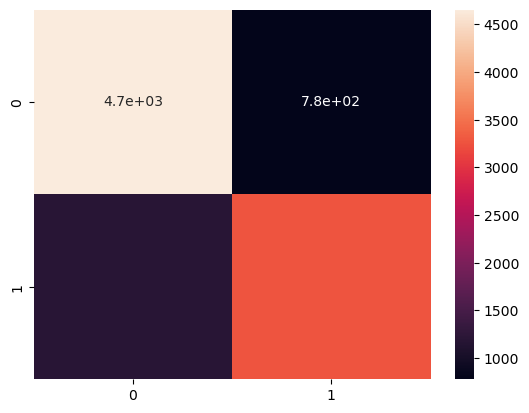

In [146]:
# predicting the test set results with custom threshold
y_preds_cust_thresh = model_best.model.predict(test_Xle, verbose = 0)
y_preds_cust_thresh = (y_preds_cust_thresh > 0.1)

# Making the confusion matrix 
conf_mat_best = confusion_matrix(test_yle, y_preds_cust_thresh)
sns.heatmap(conf_mat_best, annot = True)

# Creating a classification report
class_report = classification_report(test_yle, y_preds_cust_thresh)
print("\nClassification Report:\n", class_report)

By drastically altering the threshold in this way, we can see that the F1 scores are more balanced and there is less of a discrepancy between the FN vs FP classificationrates.

### Cross Validation on 'Best' NN

Using K-fold as the cross validation model validation technique. Since the dataset is fairly large, we selected 20 folds so that it will run more efficiently.

In [149]:
def create_best_model_CV():
    """
    Creates best Keras sequential model given the hyperparameter
    search above.
    
    Returns the compiled Keras sequential model created for binary 
    classification.
    """
    
    # defining sequential model
    best_model = tf.keras.Sequential()
    
    # Hidden layer #1
    best_model.add(Dense(6, input_dim = train_Xle.shape[1], kernel_initializer = "he_normal"))
    best_model.add(Activation('relu'))
    
    # Hidden layer #2
    best_model.add(Dense(64, kernel_initializer = "he_normal"))
    best_model.add(Activation('relu'))
    
    # Hidden layer #3
    best_model.add(Dense(128, kernel_initializer = "he_normal"))
    best_model.add(Activation('relu'))
    
    # Hidden layer #4
    best_model.add(Dense(64, kernel_initializer = "he_normal"))
    best_model.add(Activation('relu'))
    
    # Dropout layer
    best_model.add(Dropout(0.2))
    
    # Output layer
    best_model.add(Dense(1))
    
    # Compiling the model
    best_model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer = 'adam',
        metrics = ['accuracy']
    )
    
    return best_model

In [150]:
# Creating the model
best_nn_model = KerasClassifier(
    build_fn = create_best_model_CV, 
    epochs = 50, 
    batch_size = 16, 
    verbose = 0
)

best_nn_model

KerasClassifier(
	model=None
	build_fn=<function create_best_model_CV at 0x19203fc40>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=16
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	class_weight=None
)

In [151]:
#prevent long warning string from appearing
warnings.filterwarnings('ignore')

# evaluating using 20-fold cross validation
kfold = KFold(n_splits = 20, shuffle = True, random_state = 42)
results = cross_val_score(best_nn_model, test_Xle, test_yle, cv = kfold)

In [152]:
print("The minimum accuracy across 20 folds of the testing data is", round(results.min()*100, 2), "%")
print("The maximum accuracy across 20 folds of the testing data is", round(results.max()*100, 2), "%")
print("The average accuracy across 20 folds of the testing data is", round(results.mean()*100, 2), "%")
print("The the standard deviation of accuracy across 20 folds of the testing data is", 
      round(results.std(), 2))

The minimum accuracy across 20 folds of the testing data is 74.95 %
The maximum accuracy across 20 folds of the testing data is 80.81 %
The average accuracy across 20 folds of the testing data is 78.3 %
The the standard deviation of accuracy across 20 folds of the testing data is 0.01


On average, the 'best' NN with 4 hidden layers containing 6, 64, 128, and 64 neurons using ReLU activation, the 'he_normal' kernel initializer, a batch size of 16, and 50 epochs performs well with a testing accuracy of 81.49 %. Using 20-fold CV, we can see that this aaccuracy tends to deviate by about 2 % depending on the split, and can achieve testing accuracies as low as 73.79 % or as high as 78.74 %. 

Text(0.5, 1.0, 'Training Accuracy Across 20-Folds')

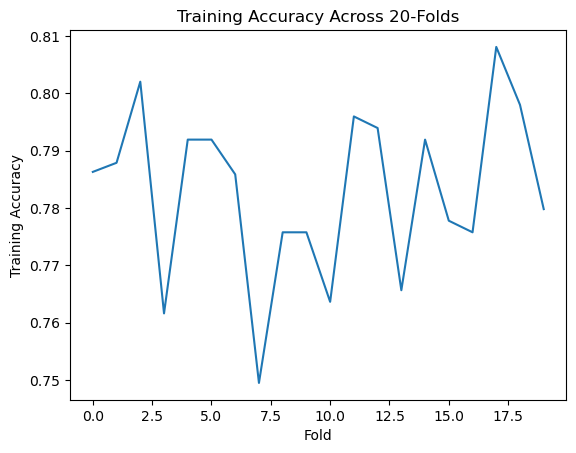

In [154]:
# visualization of the accuracy curve over the 20-folds
plt.plot(results)
plt.xlabel("Fold")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy Across 20-Folds")

Results of the 20-fold CV are positive as the convey the model can perform similarly well across random splits of the data, suggesting it supplies results with consistent accuracies and accuracies between the mid-70s and low 80s are not just random luck.


### Check with Fionnuala!!!

Despite the fact that the 'best' NN model performs, on average, with a fairly high testing accuracy of 78.74 %, the ML model built using the Random Forest classifier tends to perform better than the NN, thus will be used to make classifications on our real estate data.

# Conclusion
## Discussion of Findings

Revisiting our project goals, we were able to:

1. Gain insights on what factors effect real-estate prices
- We found house size, income, number of bathrooms, and acreage to be most important while the number of bedrooms and overall social and fiscal aspects of each state like biden and trump vote percentage and minimum wage were least important when predicting whether a property is “expensive” or “not expensive” for that state.

2. Compare what models are most effective in predicting whether a sample is expensive
- We created and tested many ML models and NN and found a Random Forest classifier to perform best when classifying a property as “expensive” or “not expensive” for that state based on whether it is above or below the states median house cost.

3. Obtain a high accuracy score
- Using a *Random Forest classification model*, we were able to construct a model with 8 features that achieves a [insert]% training accuracy and a [insert]% training accuray when conducting classification.

## Limitations
Despite using many important features and standardizing our numerical real estate data, testing accuracy was in the low 80s and ideally we can curate a model that achieves higher accuracy in the 90s. Given the models and techniques we utilized, no categorical data was included. However, the addition of these types of variables might add crucial information that can improve model accuracy. 

Additionally, this model is practical in the sense that it can categorize binary classifications of “expensive” or “not expensive” per state, but it is potentially less useful than actually predicting property price.